# Testing a model template

In [27]:
# Packages used for developing models, as well as processing information

from IPython import get_ipython
from IPython.display import display
# %%
from sklearn.svm import SVC
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from warnings import filterwarnings
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


filterwarnings('ignore')

In [127]:

#Reading the database and checking some information
#I purposely eliminated some information from the data set so that I could apply methods to fill
#in empty fields and transform text data into numeric values.

Dataset = pd.read_csv('breast_cancer.csv',sep=';', on_bad_lines='skip')


In [30]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              565 non-null    float64
 1   mean texture             566 non-null    float64
 2   mean perimeter           566 non-null    float64
 3   mean area                568 non-null    float64
 4   mean smoothness          566 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [31]:
Dataset.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,565.000000,566.000000,566.000000,568.000000,566.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,711.656867,19.291343,91.869399,654.637500,0.096259,0.104341,0.088799,0.048919,0.181162,0.062798,...,315.194921,25.677223,107.261213,880.583128,0.132369,2.111808,4.410401,0.114606,0.290076,0.083946
std,2438.148614,4.309063,24.290511,352.173096,0.013926,0.052813,0.079720,0.038803,0.027414,0.007060,...,1655.459336,6.146258,33.602542,569.356993,0.022832,44.343334,69.928599,0.065732,0.061867,0.018061
min,7.760000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,12.200000,16.172500,75.065000,420.175000,0.086380,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.180000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.850000,18.835000,86.140000,548.750000,0.095865,0.092630,0.061540,0.033500,0.179200,0.061540,...,15.150000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,17.600000,21.807500,104.025000,782.625000,0.105250,0.130400,0.130700,0.074000,0.195700,0.066120,...,19.850000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9904.000000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,9981.000000,49.540000,251.200000,4254.000000,0.222600,1058.000000,1252.000000,0.291000,0.663800,0.207500


# Checking Some Measurements

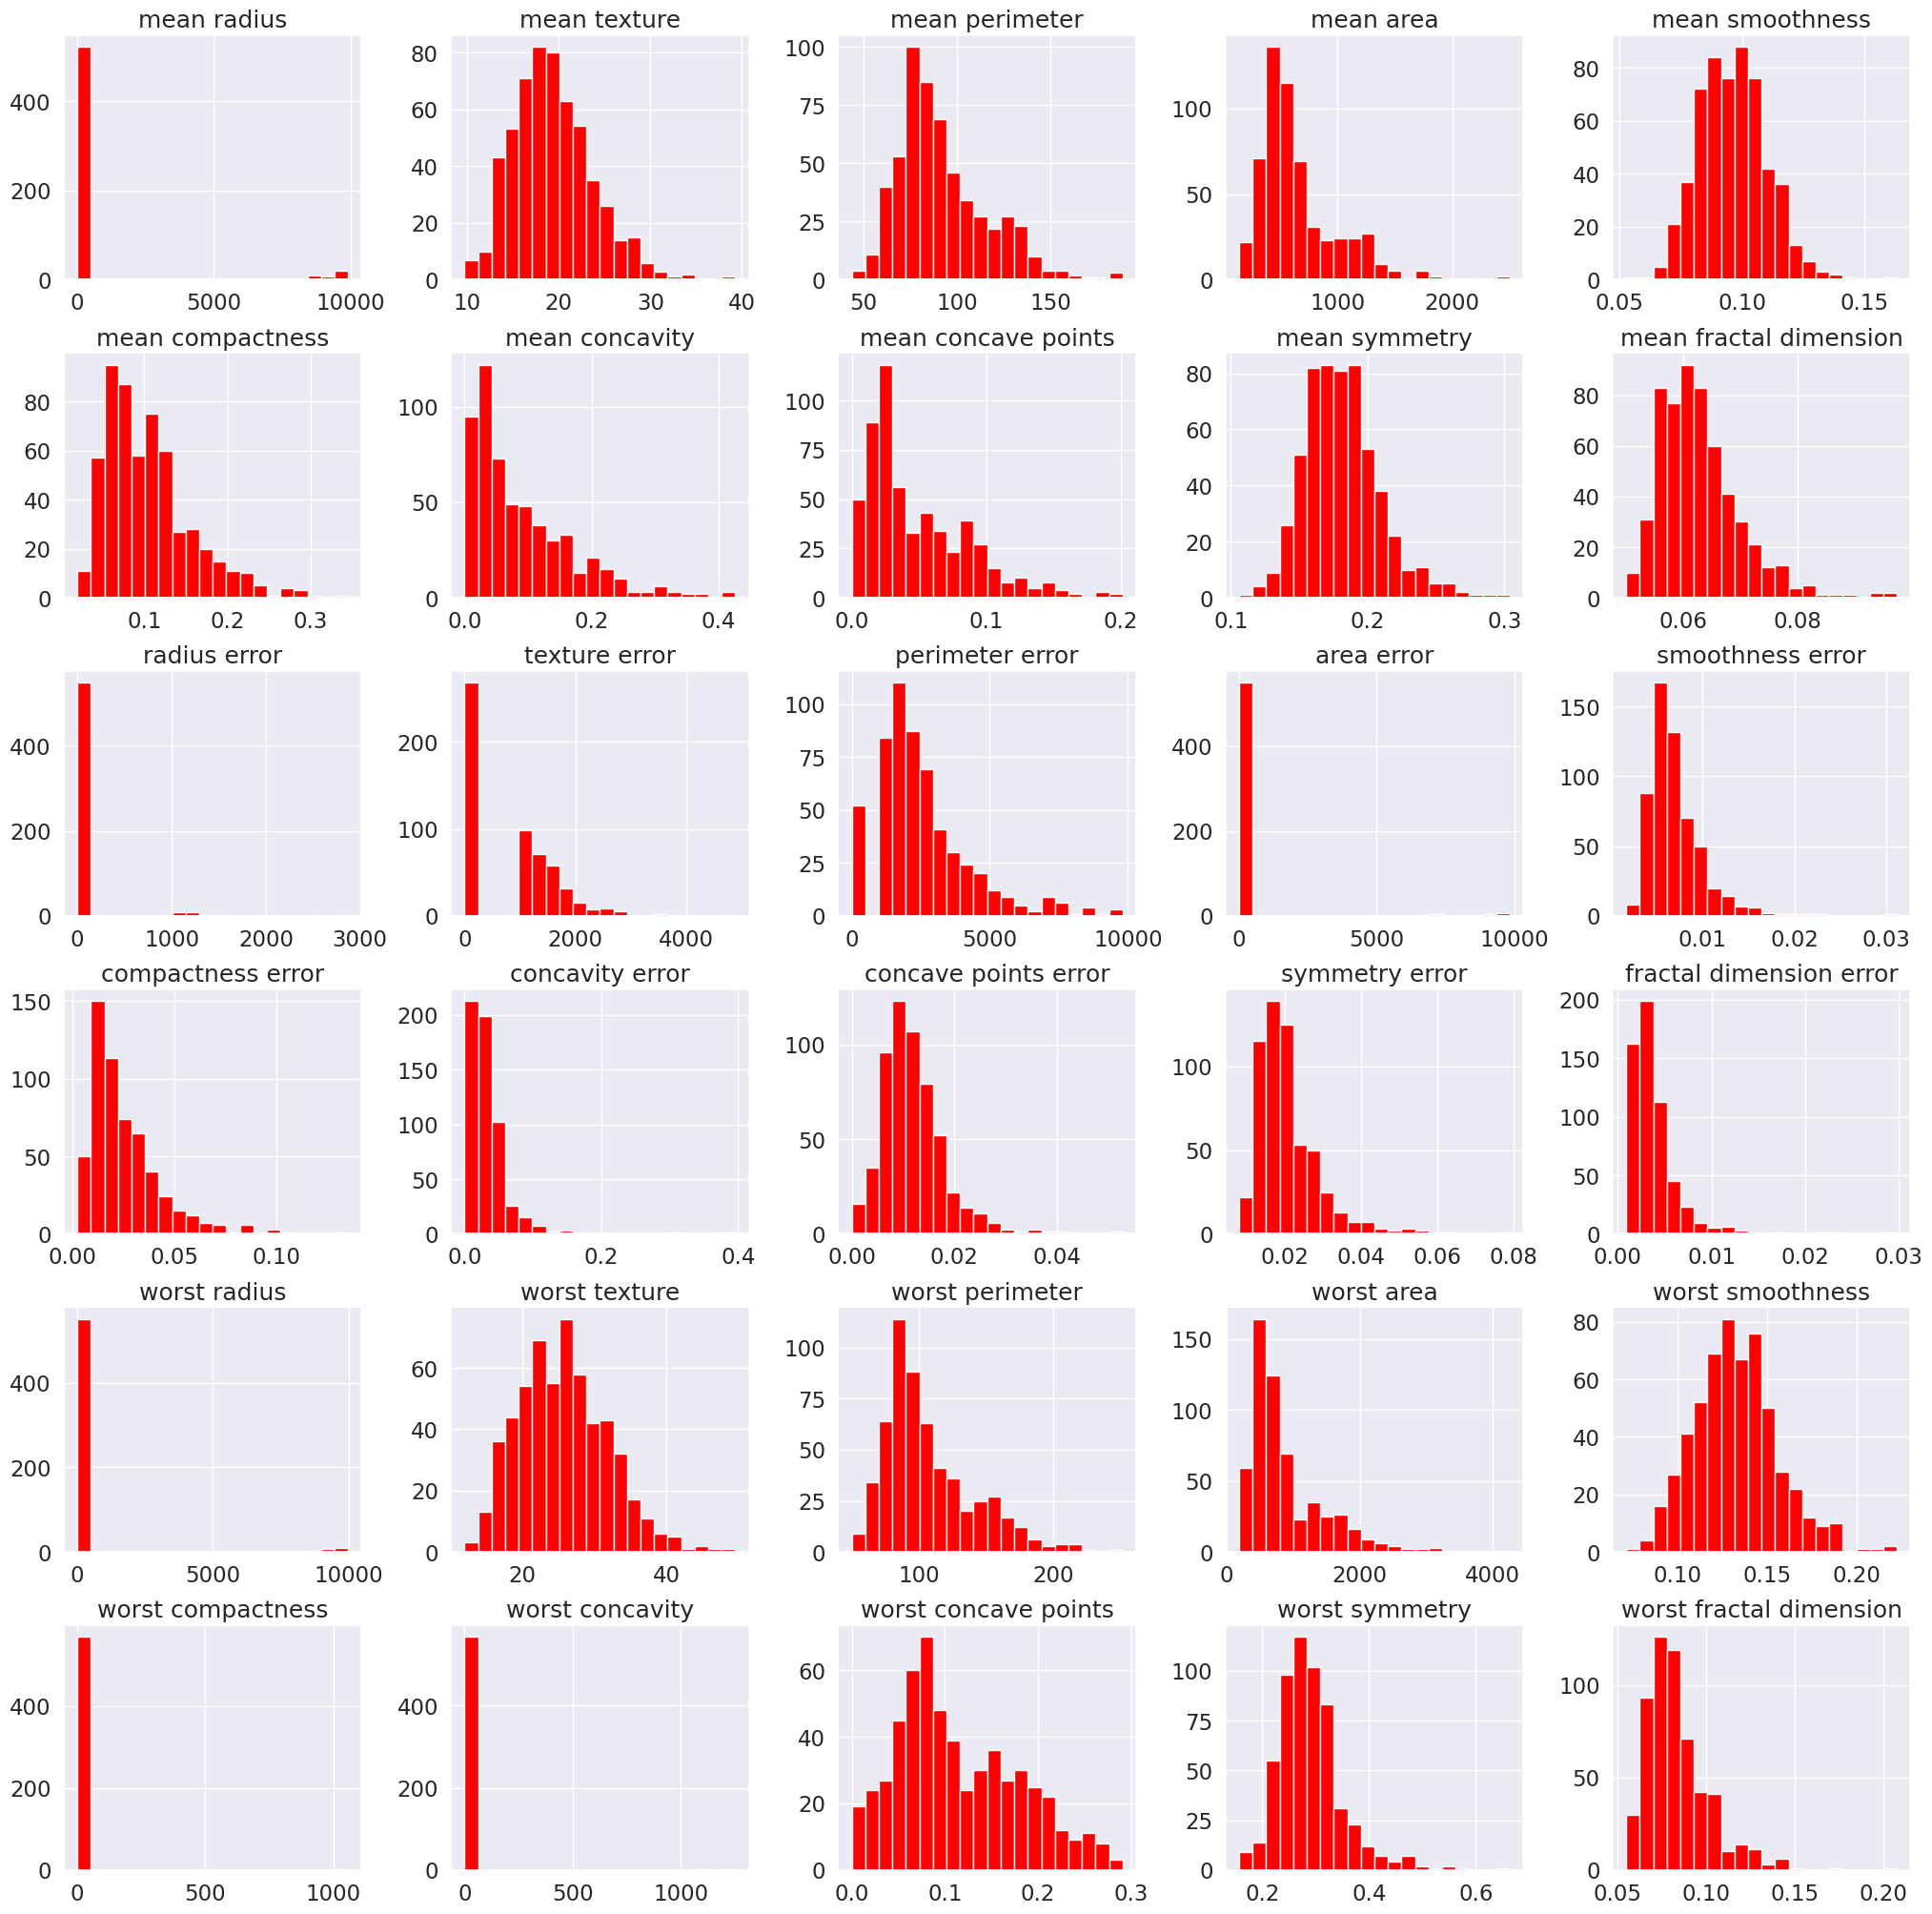

In [33]:
sns.set(font_scale=1.5,rc={'figure.figsize':(25,25)}) #usando a biblioteca sns posso verificar algumas distribuições dos meus dados
eixo=Dataset.hist(bins=20,color='red')

# Processing Some Variables

In [116]:
class processing_data:
  def __init__(self,base=None,label='Processing Dataset'):
    self.base = base
    self.label = label
    self.min_max_scaler = MinMaxScaler()


  def float_values(self, str_var):
        textos = self.base.select_dtypes(include=['object']).columns
        for column in textos:
            if column not in str_var:
                self.base[column] = self.base[column].str.replace(',', '.').astype(float)
        return self.base

  #if my target is a text I transform in dummy value
  def target_variable(self,X,variavel):
    self.base['target'] = np.where(self.base['target']==variavel, 1, 0)
    return self.base

  # transform in dummies some variables
  def dummy_df(self,X,dummies):
      X = pd.get_dummies(X, prefix=dummies, columns=dummies,dtype='int')
      return X

  def normalize_df(self,X):
    #Normalize the data
    column_to_move = X.pop("target")
    X['target'] = column_to_move

    Lista_variaveis = X.columns[:-1]
    X=X.iloc[:,:-1]
    y=column_to_move.values
    X =pd.DataFrame(data=X, columns=Lista_variaveis)
    min_max_scaler =MinMaxScaler()
    X = self.min_max_scaler.fit_transform(X)
    return X,y,Lista_variaveis

  def impute_values(self, X, type_method):
        # Get the indices of columns with missing values within the impute_values method
        missing_cols_indices = [i for i, col in enumerate(X.columns) if X[col].isnull().any()]
        imputer = SimpleImputer(missing_values=np.nan, strategy=type_method)
        X_df = pd.DataFrame(X, columns = X.columns) # Use X.columns to ensure all columns are included

        # Impute missing values using these indices
        if missing_cols_indices:  # Check if there are any missing columns
            X_df[X_df.columns[missing_cols_indices]] = imputer.fit_transform(X_df[X_df.columns[missing_cols_indices]])

        return X_df


class models_types:
  def __init__(self,X,y,Lista_variaveis,batch_size=None,epochs=None,cluster=None,model_tree=None):
    self.X = X
    self.y = y
    self.Lista_variaveis = Lista_variaveis
    self.batch_size = batch_size
    self.epochs = epochs
    self.cluster = cluster
    self.model_tree = model_tree
    self.min_max_scaler = MinMaxScaler()

  #Neural Network Model
  def neuro_model(self):
    num_neu= len(self.Lista_variaveis)
    targ=2
    ocult_neu=int((num_neu*(2/3))+2)

    neuro=tf.keras.models.Sequential([tf.keras.layers.Dense(num_neu,input_shape=(len(self.Lista_variaveis),)
                                                  ,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(ocult_neu,activation='relu',kernel_initializer='he_normal'),
                              tf.keras.layers.Dropout(0.5),
                              tf.keras.layers.Dense(2, activation='softmax')])
    #Train setings
    neuro.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(), #or binary_crossentropy
                metrics=['accuracy'])
    # Return the compiled model instead of the fit history
    return neuro

  def cluster_model(self):
    kmeans = KMeans(n_clusters=self.cluster,init='k-means++',max_iter=300)
    return kmeans

  def tree_and_random_forest(self):
    #Decission Tree Model
    if self.model_tree == 'Decission Tree':
      tree_para = [{'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20]}]
      #GridSearchCV is a powerful tool for finding the best hyperparameters for
      #machine learning models. By using it properly and following best practices,
      #you can significantly improve the performance and accuracy of your models, saving time and effort in the process.

      clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=3)
      clf.fit(self.X,self.y)
      print('Best Parameters',clf.best_params_['criterion'],clf.best_params_['max_depth'])
      arvore = DecisionTreeClassifier(criterion=clf.best_params_['criterion'],max_depth=clf.best_params_['max_depth'])
      #tree.plot_tree(arvore.fit(Xtrain,ytrain))
      return arvore

    else:
      #test parameters to check what would be the ideal number of trees and their depth
      tuned_parameters = [{'n_estimators': [20,50,100],
                          'max_depth': [4, 5, 6]}]
      #samples for use in cross_validation
      qt_cv = 3
      clf_rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv= qt_cv, scoring='roc_auc')
      clf_rf.fit(self.X,self.y)
      RTArray = []
      print('Best Parameters',clf_rf.best_params_['n_estimators'],clf_rf.best_params_['max_depth'])
      clf_rf = RandomForestClassifier(
                    n_estimators = clf_rf.best_params_['n_estimators'],
                    max_depth = clf_rf.best_params_['max_depth'])

      #clf_rf.fit(Xtrain, ytrain)
      return clf_rf


  def knn_model(self):

    knn_para = [{'n_neighbors':[2,3,4,5],'p':[1,2]}]

    #KNN MODEL
    knn = GridSearchCV(KNeighborsClassifier(), knn_para, cv=3)
    knn.fit(self.X,self.y)
    print('Best Parameters',knn.best_params_)
    knn_f = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'],p=knn.best_params_['p'])
    return knn_f

  def svm_model(self):
    svm_para = [{'kernel':['linear','poly','sigmoid'],
             'degree':[4,5]}]
    #Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)
    #svm = GridSearchCV(SVC(), svm_para, cv=3)
    #svm.fit(Xtrain,ytrain)
    #print(svm.best_params_)

    #svm_f = SVC(kernel=svm.best_params_['kernel'],degree=svm.best_params_['degree'])
    svm_f = SVC(kernel='rbf',degree=5,probability=True)
    return svm_f

  def logistic_model(self):
    log_para=[{'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],'max_iter':[10,20,50,100,150,200]}]

    log = GridSearchCV(LogisticRegression(), log_para, cv=3)

    log.fit(self.X,self.y)
    print('Best Parameters',log.best_params_)
    log_f = LogisticRegression(solver=log.best_params_['solver'],max_iter=log.best_params_['max_iter'])
    return log_f

  def models_metrics_neuro(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain, batch_size=self.batch_size, epochs=self.epochs)
    probs = np.round(model.predict(Xtest, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    #Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    #This test compares the underlying continuous distributions F(x) and G(x) of two independent samples
    print('\nKS  Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))
    print('\n')
    probs = np.round(model.predict(Xtrain, verbose=0)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print((probs.max(),probs.min()))

  def models_metrics(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    probs = np.round(model.predict_proba(Xtest)[:,1], 7)

    fpr, tpr, thresholds = roc_curve(ytest, probs)
    print('\n KS Validation: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n ',(probs.max(),probs.min()))

    probs = np.round(model.predict_proba(Xtrain)[:,1], 7)
    fpr, tpr, thresholds = roc_curve(ytrain, probs)
    print('\n  KS Development: {0:.2f}% e AUC: {1:.2f}%'.format(stats.ks_2samp(fpr, tpr)[0] * 100.0, auc(fpr, tpr) * 100))
    print('\n',(probs.max(),probs.min()))

  def models_metrics_random_tree(self,model, Xtrain,ytrain,Xtest,ytest):
    model.fit(Xtrain, ytrain)
    #I check how the variables behave in my model, whether they are good or not
    #this can help eliminate some variables and thus select a more precise group of information
    feature_importances = pd.DataFrame(model.feature_importances_,
                                      index = self.Lista_variaveis,
                                        columns=['importance']).sort_values('importance',ascending=False)

    print(feature_importances.count())

    feat_imp_all = feature_importances.sort_values(ascending=True, by='importance')
    graf_all = feat_imp_all.plot(kind = 'barh', color = 'blue', title='Variables', figsize=(15,15), grid = False )

  def models_metrics_log(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    model.fit(Xtrain, ytrain)
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': self.Lista_variaveis, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

  def models_metrics_svm(self,model, Xtrain,ytrain,Xtest,ytest):
    #I can check the variables that were most relevant within my model
    perm_importance = permutation_importance(model, Xtest, ytest)

    feature_names = self.Lista_variaveis
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

  def scoring_fn(self,model, X, y):
      y_pred = np.argmax(model.predict(X, verbose=0), axis=1)  # Get predicted classes
      return accuracy_score(y, y_pred)  # Calculate accuracy


# Model Development and Results - Pipeline

In [128]:

processor = processing_data(base=Dataset.copy())
target='Malignant'
type_method='mean'

main_pipeline=Pipeline([('float_values', FunctionTransformer(processor.float_values,
                                                             validate=False)),
                        ('target variable', FunctionTransformer(processor.target_variable,
                                            kw_args={'variavel': target},validate=False)),
                       # ('Dummies', FunctionTransformer(processor.dummy_df,
                       #                     kw_args={'dummies': dummies},validate=False)),
                        ('Imput Values', FunctionTransformer(processor.impute_values,kw_args={'type_method':type_method},
                                                             validate=False)),
                        ('Normalize', FunctionTransformer(processor.normalize_df,validate=False)),

                        ])

X,y,Lista_variaveis=main_pipeline.fit_transform(Dataset)


Text(0.5, 1.0, 'Correlation Graph between Variables \n')

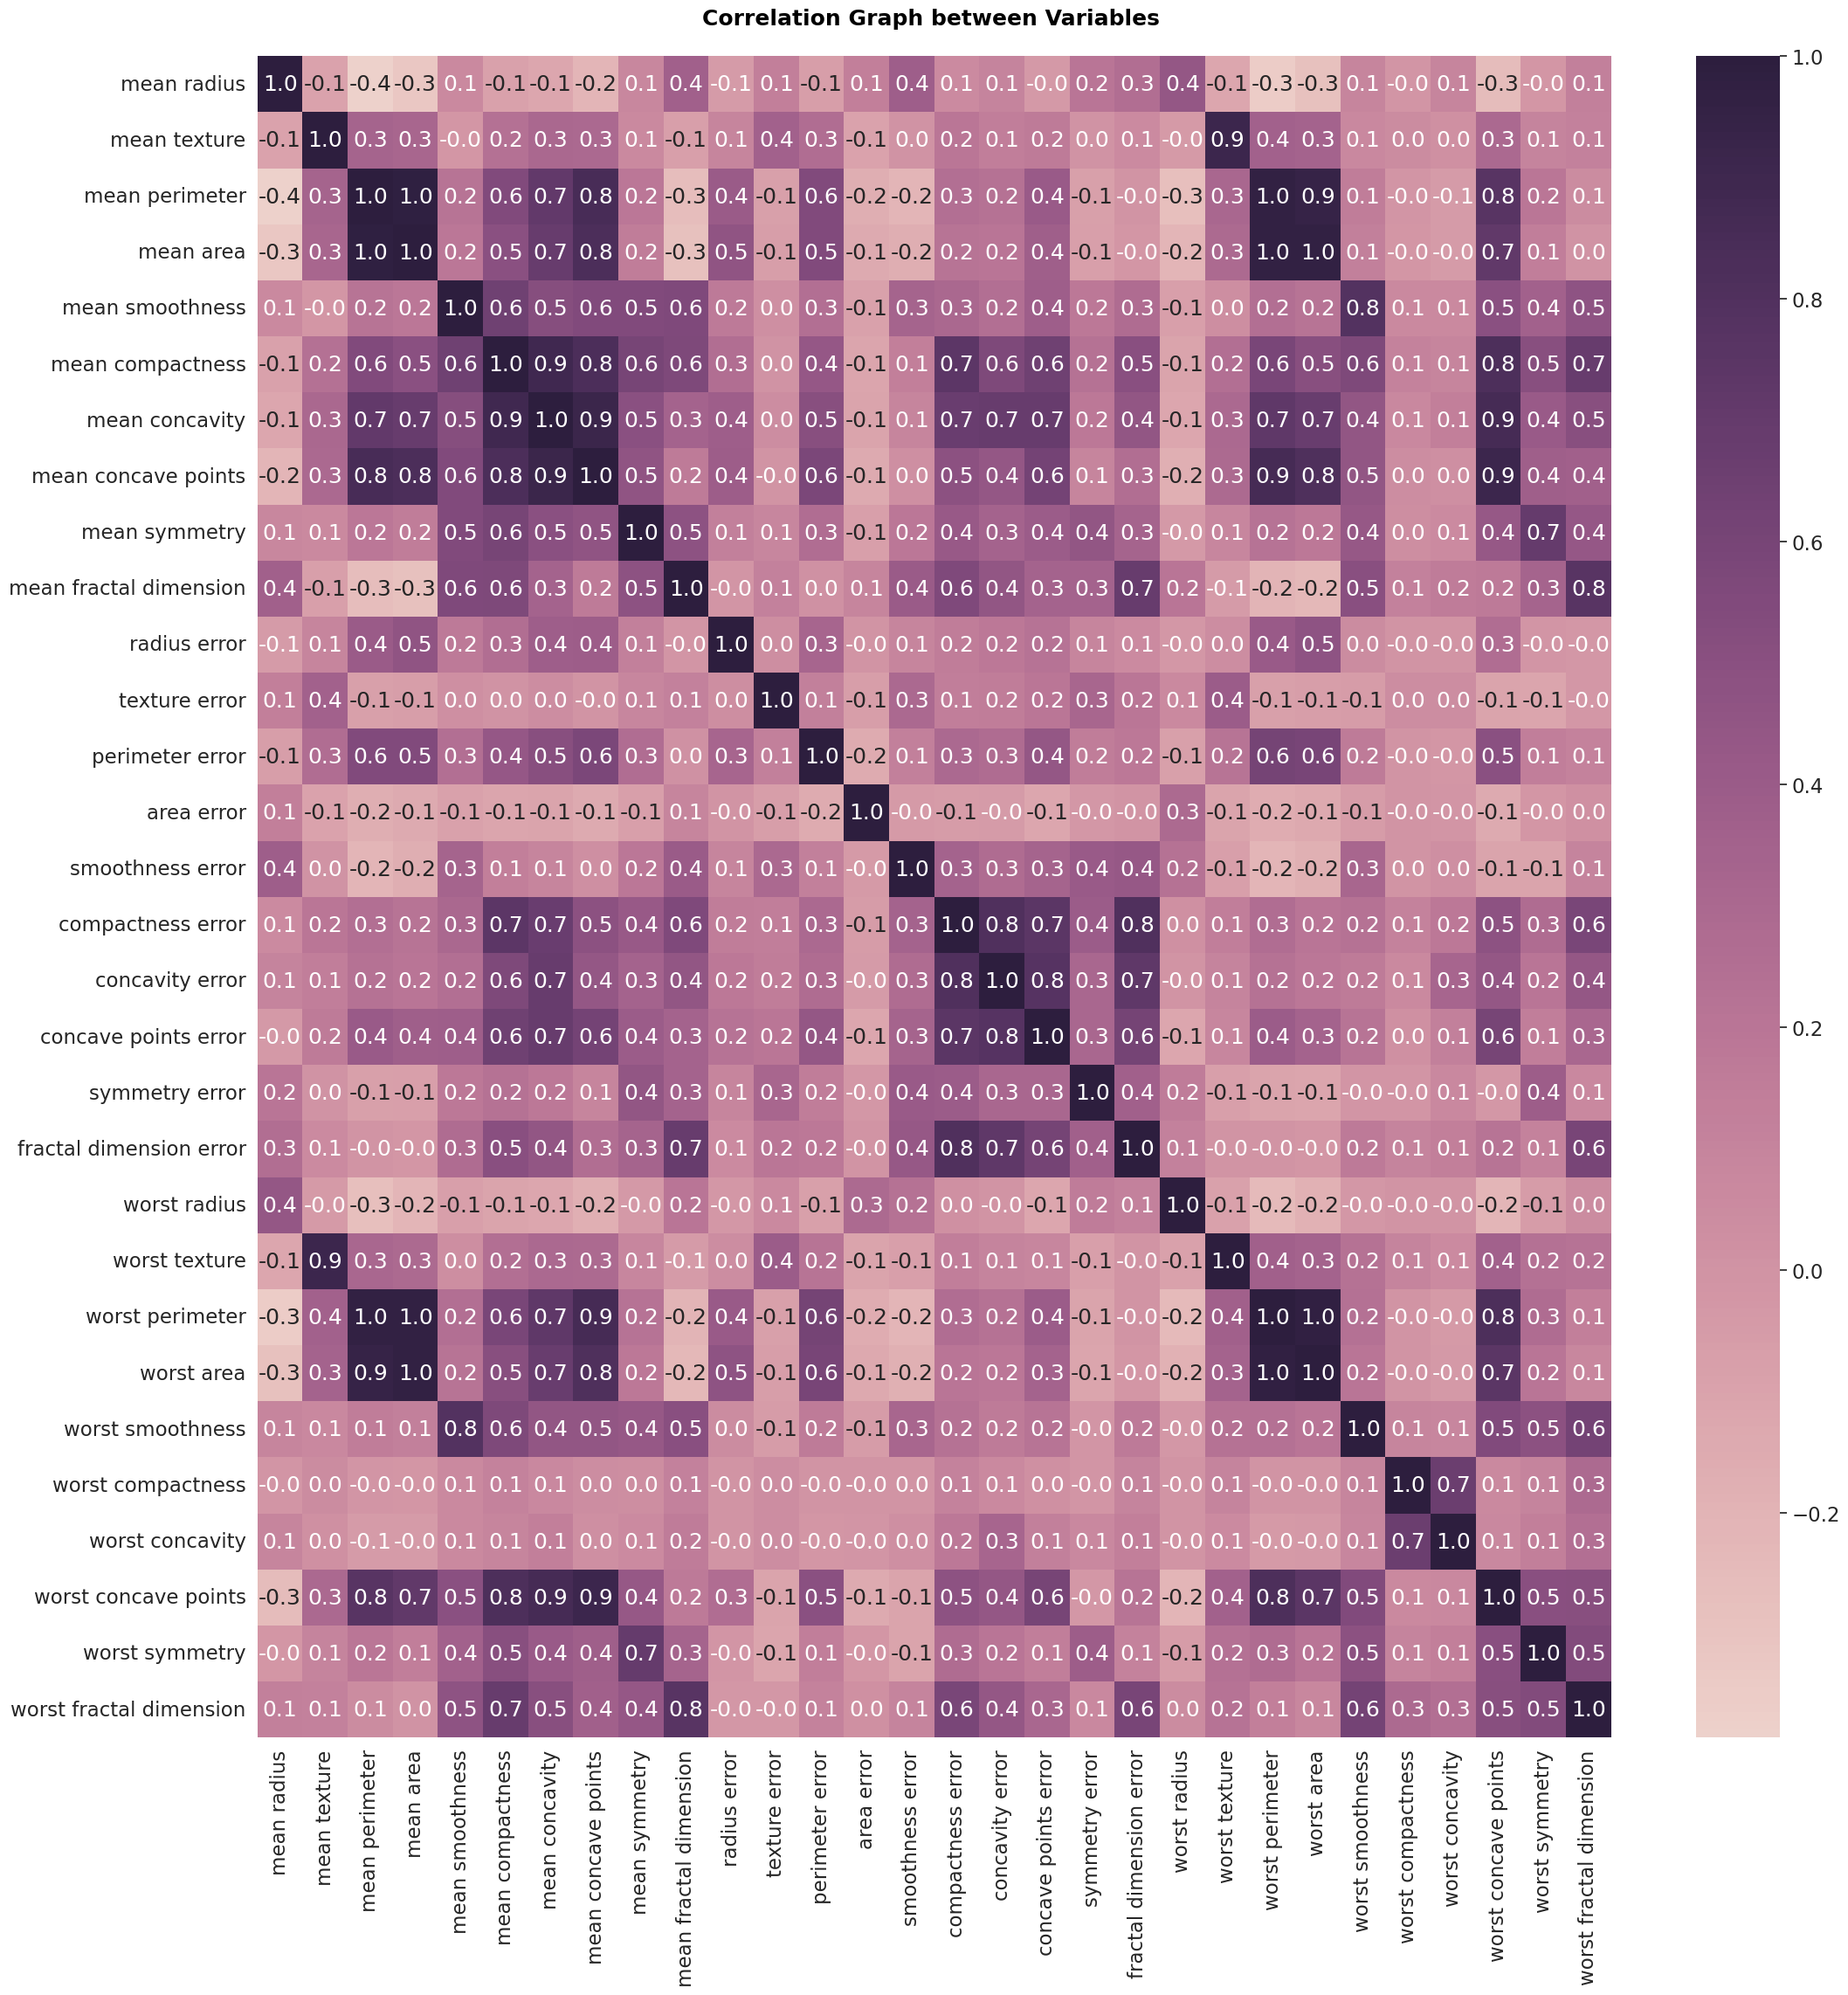

In [87]:
# Create correlation matrix
X_df = pd.DataFrame(X, columns=Lista_variaveis)  # Specify Lista_variaveis as columns
corr_mat = X_df.corr()

# Create mask
#mask = np.zeros_like(corr_mat, dtype=bool)
#mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(corr_mat, annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

Text(0.5, 1.0, 'Correlation Graph between Variables \n')

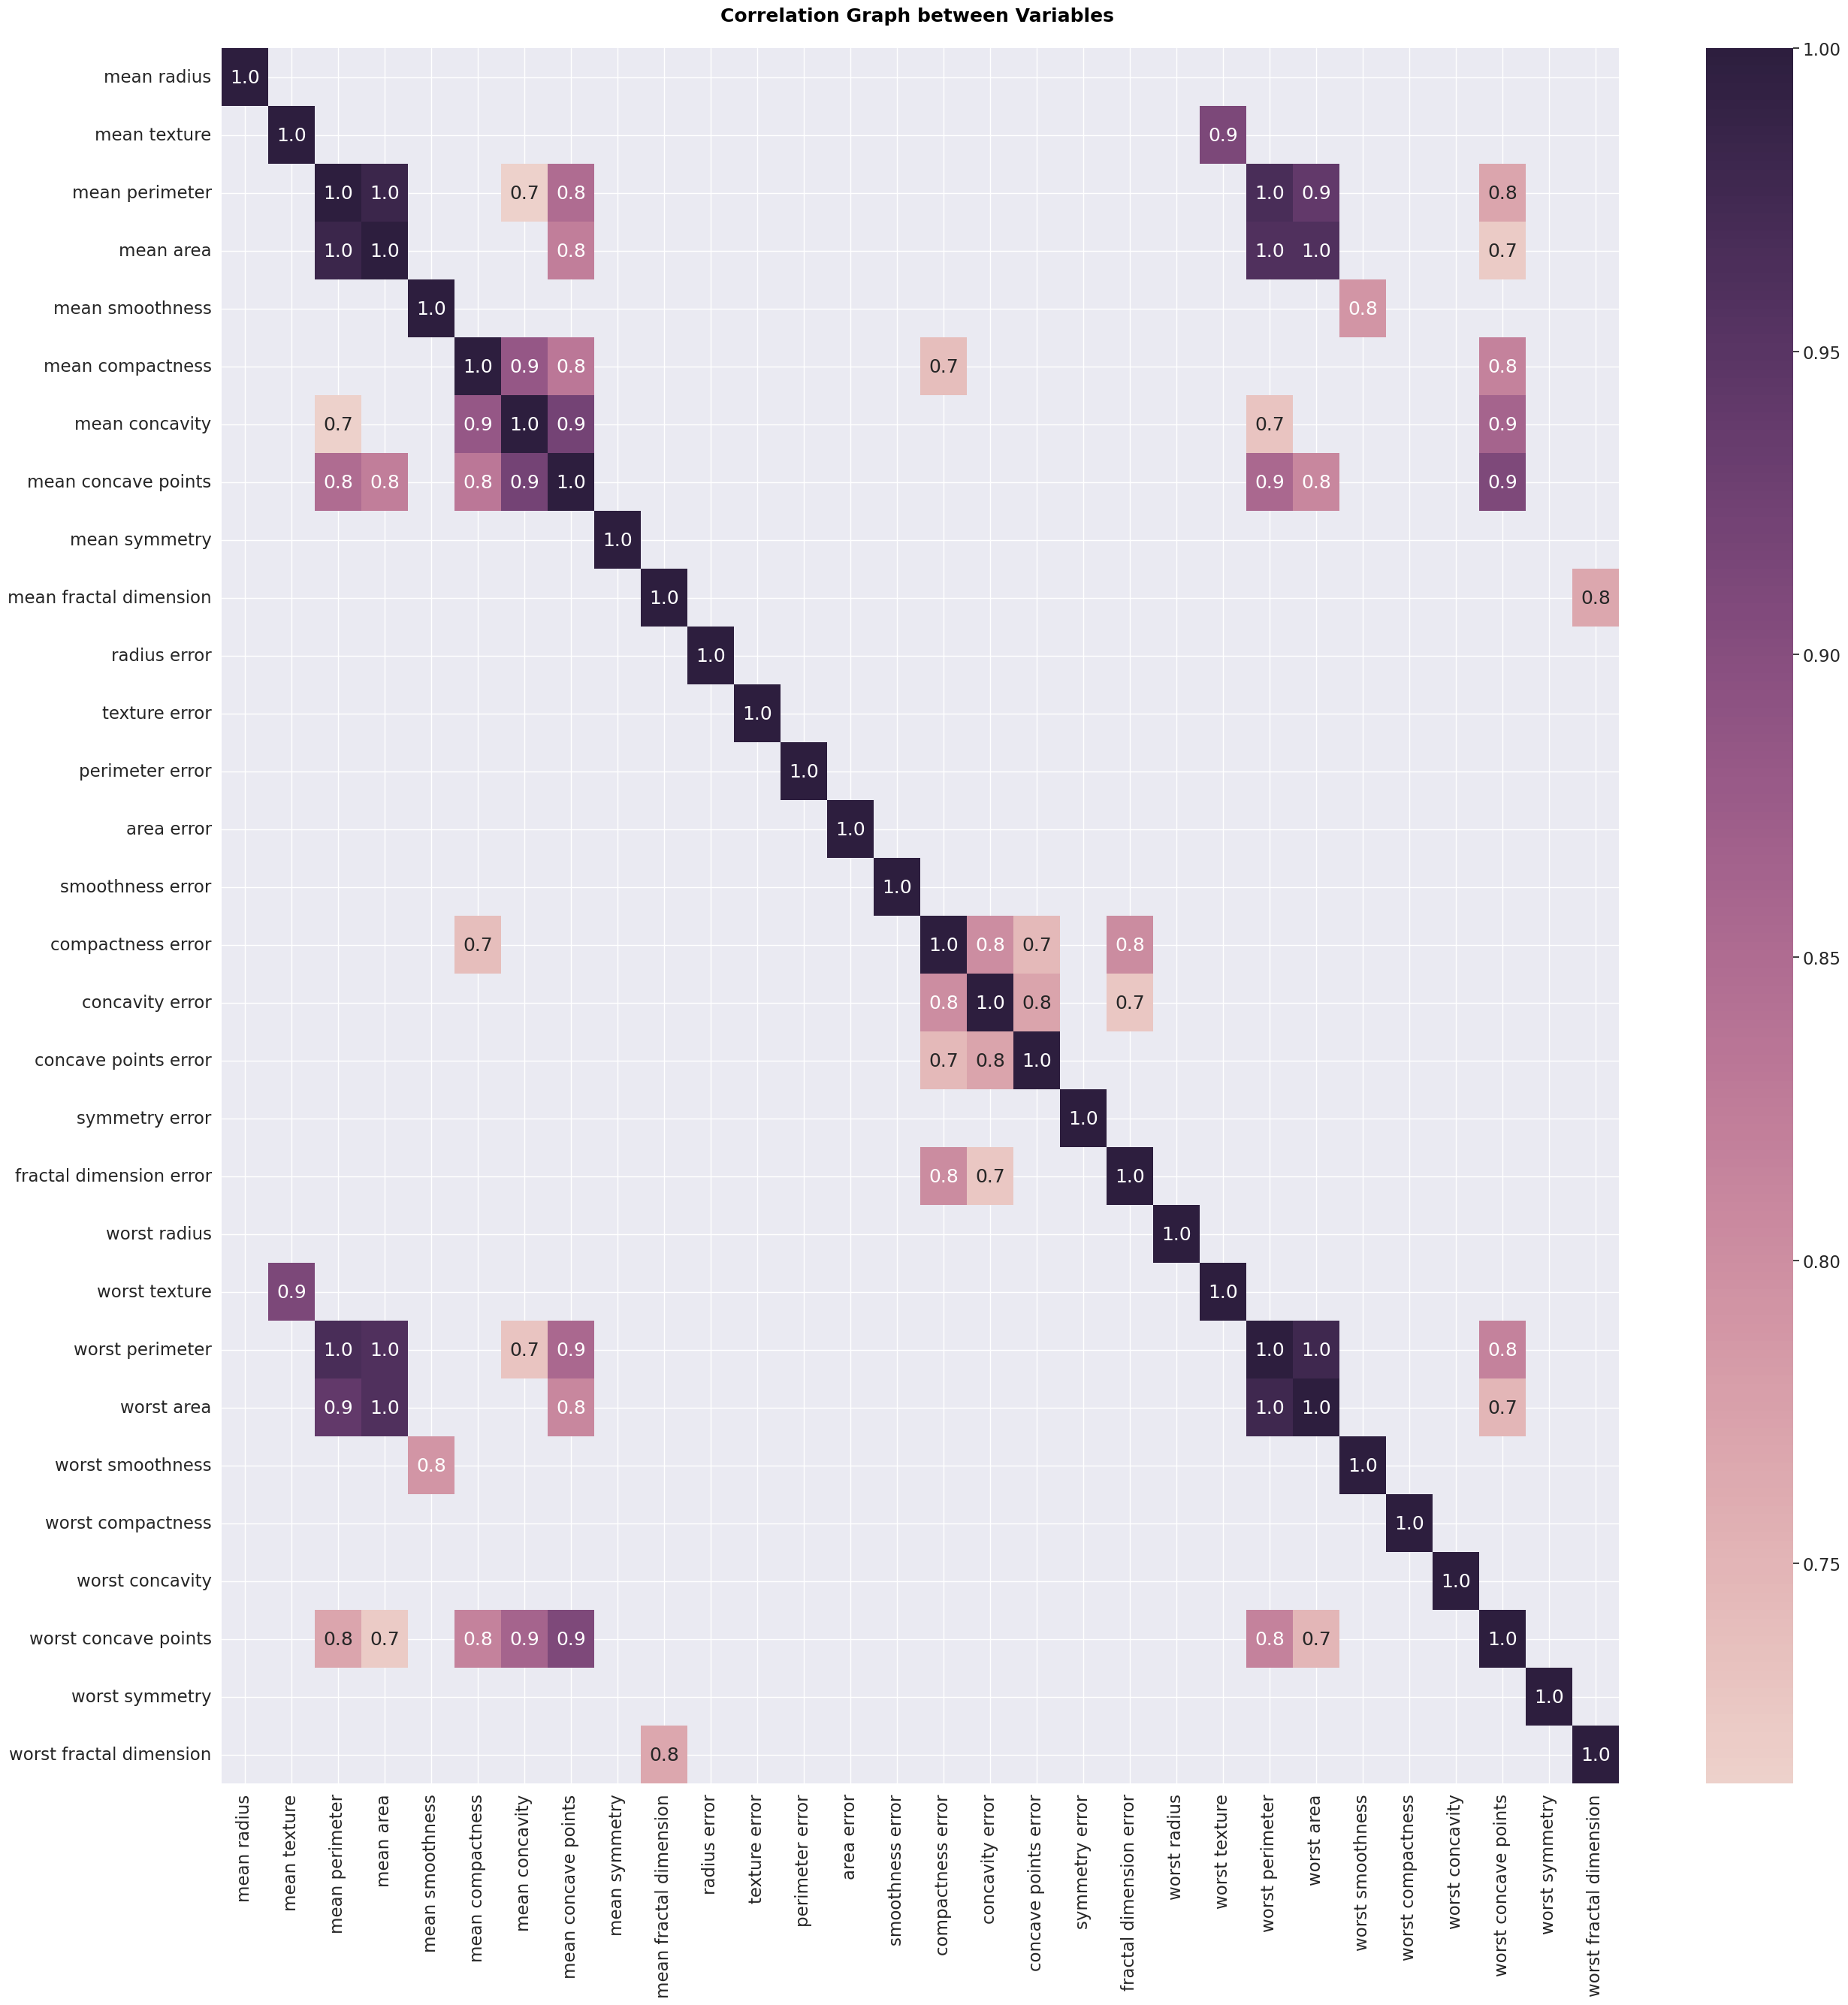

In [88]:
plt.figure(figsize=(30, 30))
sns.heatmap(corr_mat[corr_mat > 0.7], annot=True,
            fmt='.1f', cmap=sns.cubehelix_palette(200))
plt.title('Correlation Graph between Variables \n', weight="bold", color="#000000", fontsize=18)

In [91]:
import plotly.express as px

# Convert X to a pandas DataFrame with column names
X_df = pd.DataFrame(X, columns=Lista_variaveis)
X_df['target']=y
# Create the histogram using the DataFrame
histogram_diagnosis = px.histogram(X_df, x='target', color='target', title='Count Cases', text_auto=True)
histogram_diagnosis.show()

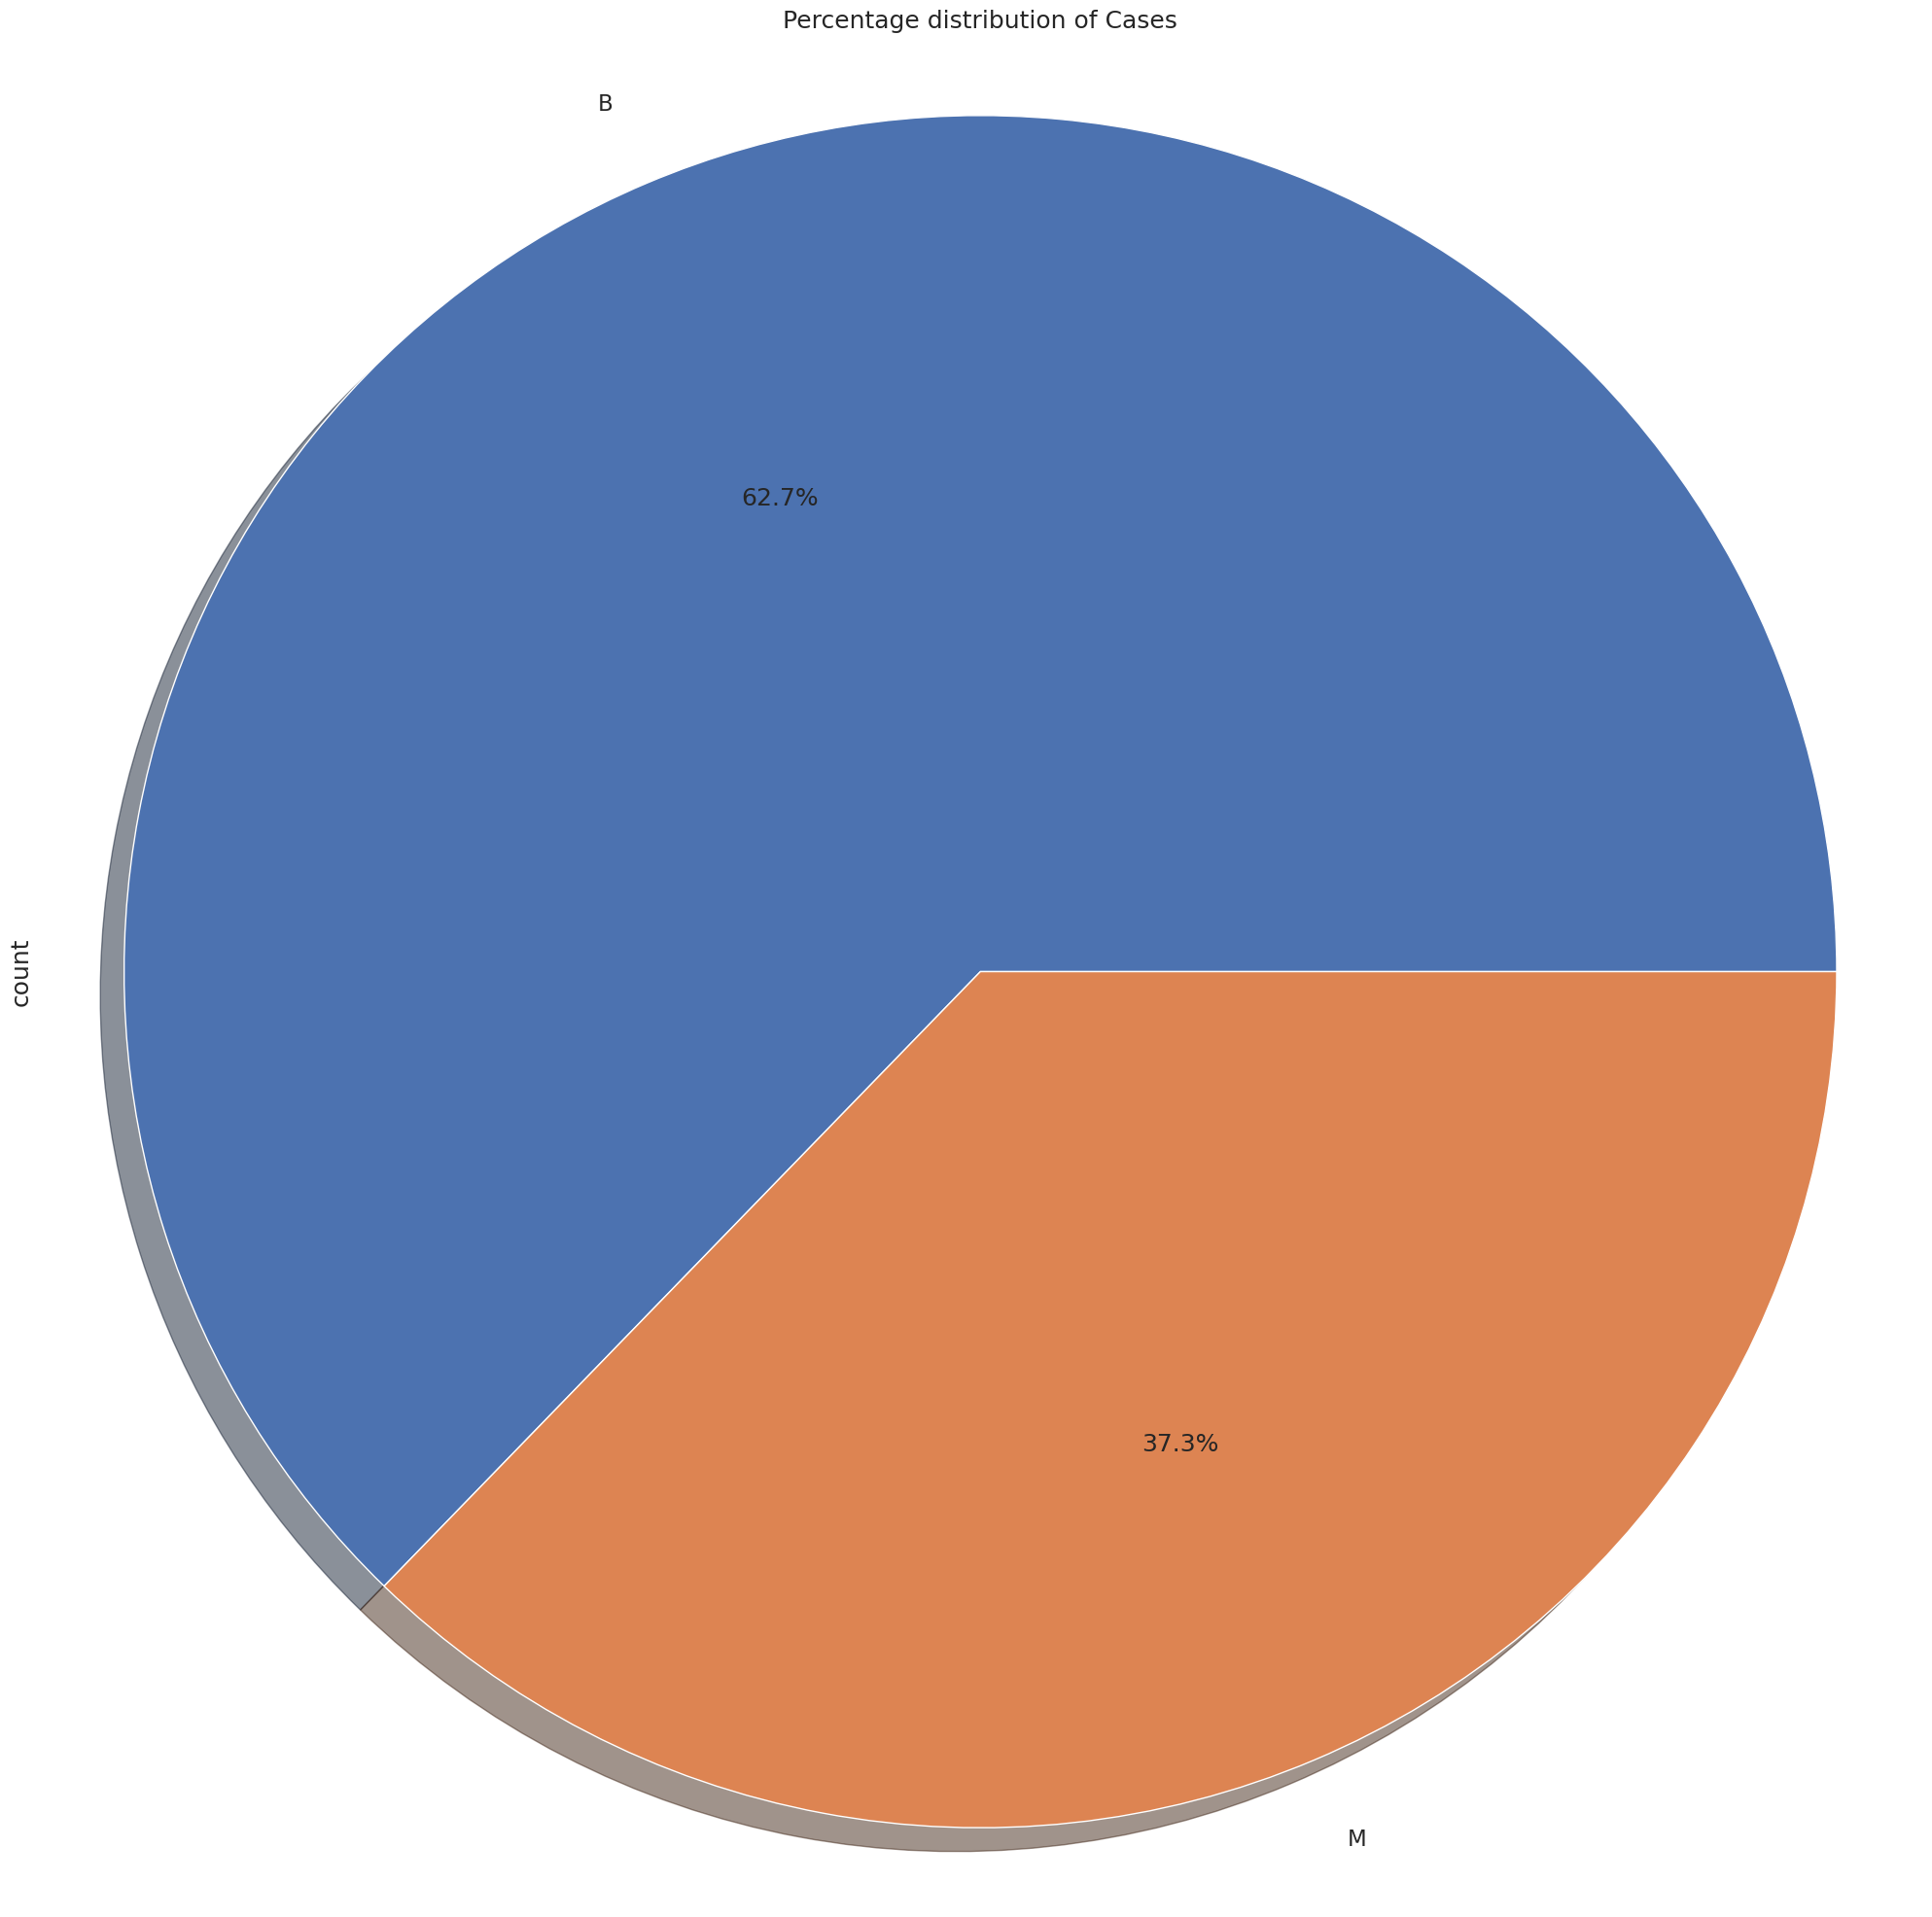

In [92]:
counts = X_df['target'].value_counts(dropna=False)
counts.plot.pie(autopct='%1.1f%%', labels=['B', 'M', 'NaN'], shadow=True)
plt.title('Percentage distribution of Cases')
plt.axis('equal')
plt.show()

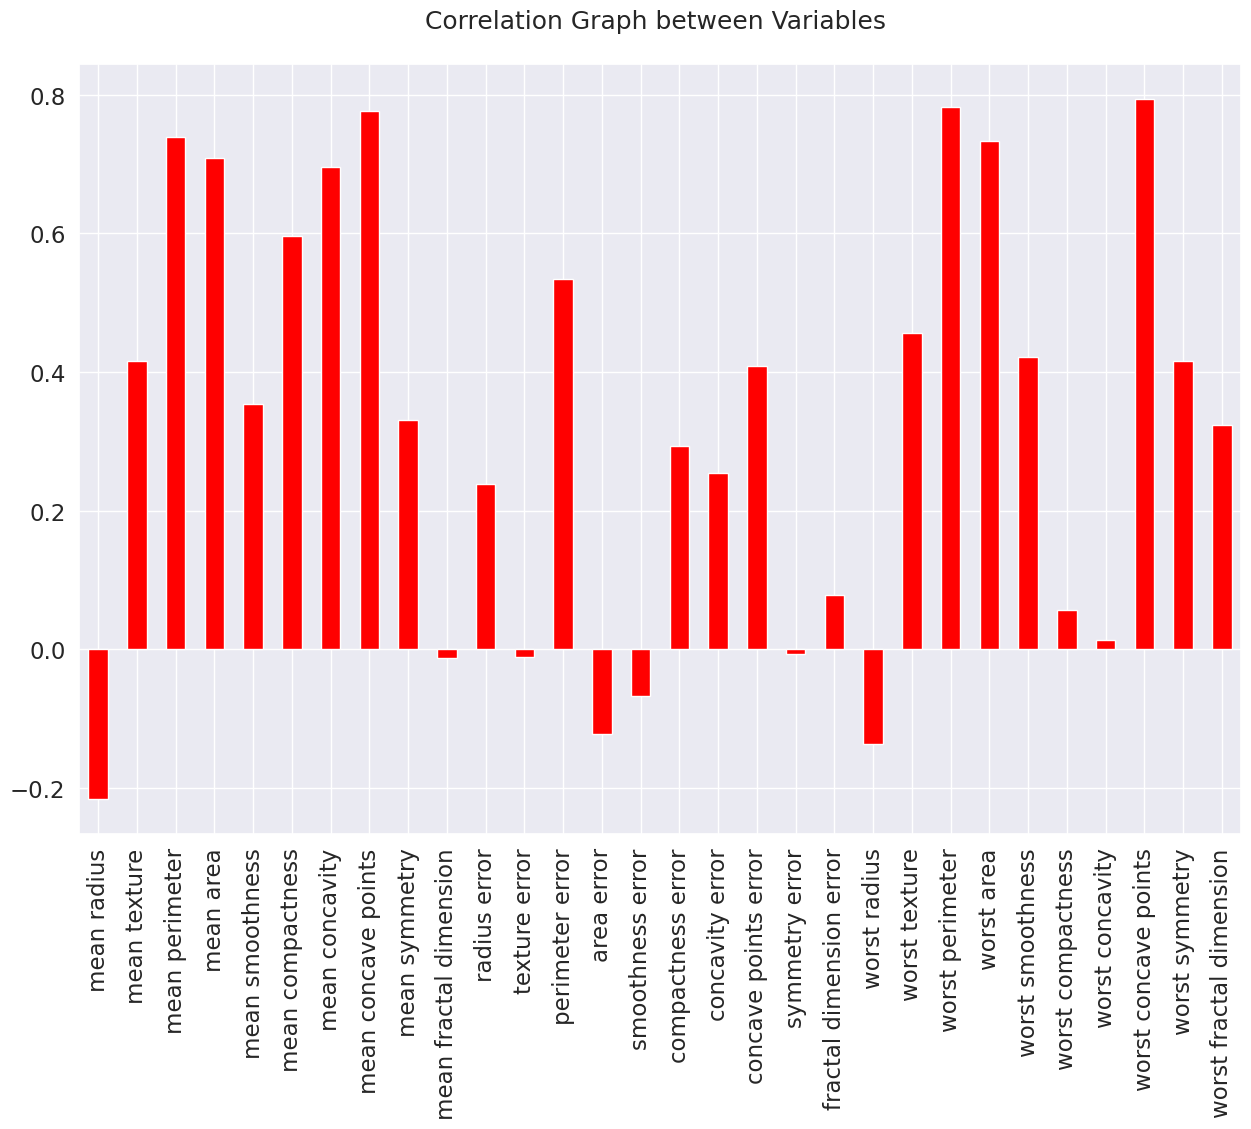

In [94]:
features = X_df.drop('target', axis=1)

correlation_with_diagnosis = features.corrwith(X_df['target'])
correlation_with_diagnosis.plot(kind='bar', grid=True, figsize=(15, 10), title="Correlation Graph between Variables \n", color="red")
plt.show()

In [95]:
batch_size=4
epochs=15
clusters=2
tree_model='Decision Tree'

Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2,random_state=0)

Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6587 - loss: 0.6505
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6960 - loss: 0.5894
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7848 - loss: 0.5119
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4938
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8444 - loss: 0.3887
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9006 - loss: 0.2912
Epoch 7/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8898 - loss: 0.2740
Epoch 8/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8882 - loss: 0.2886
Epoch 9/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9293 - loss: 0.2437
Epoch 10/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9338 - loss: 0.2080
Epoch 11/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9003 - loss: 0.2484
Epoch 12/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

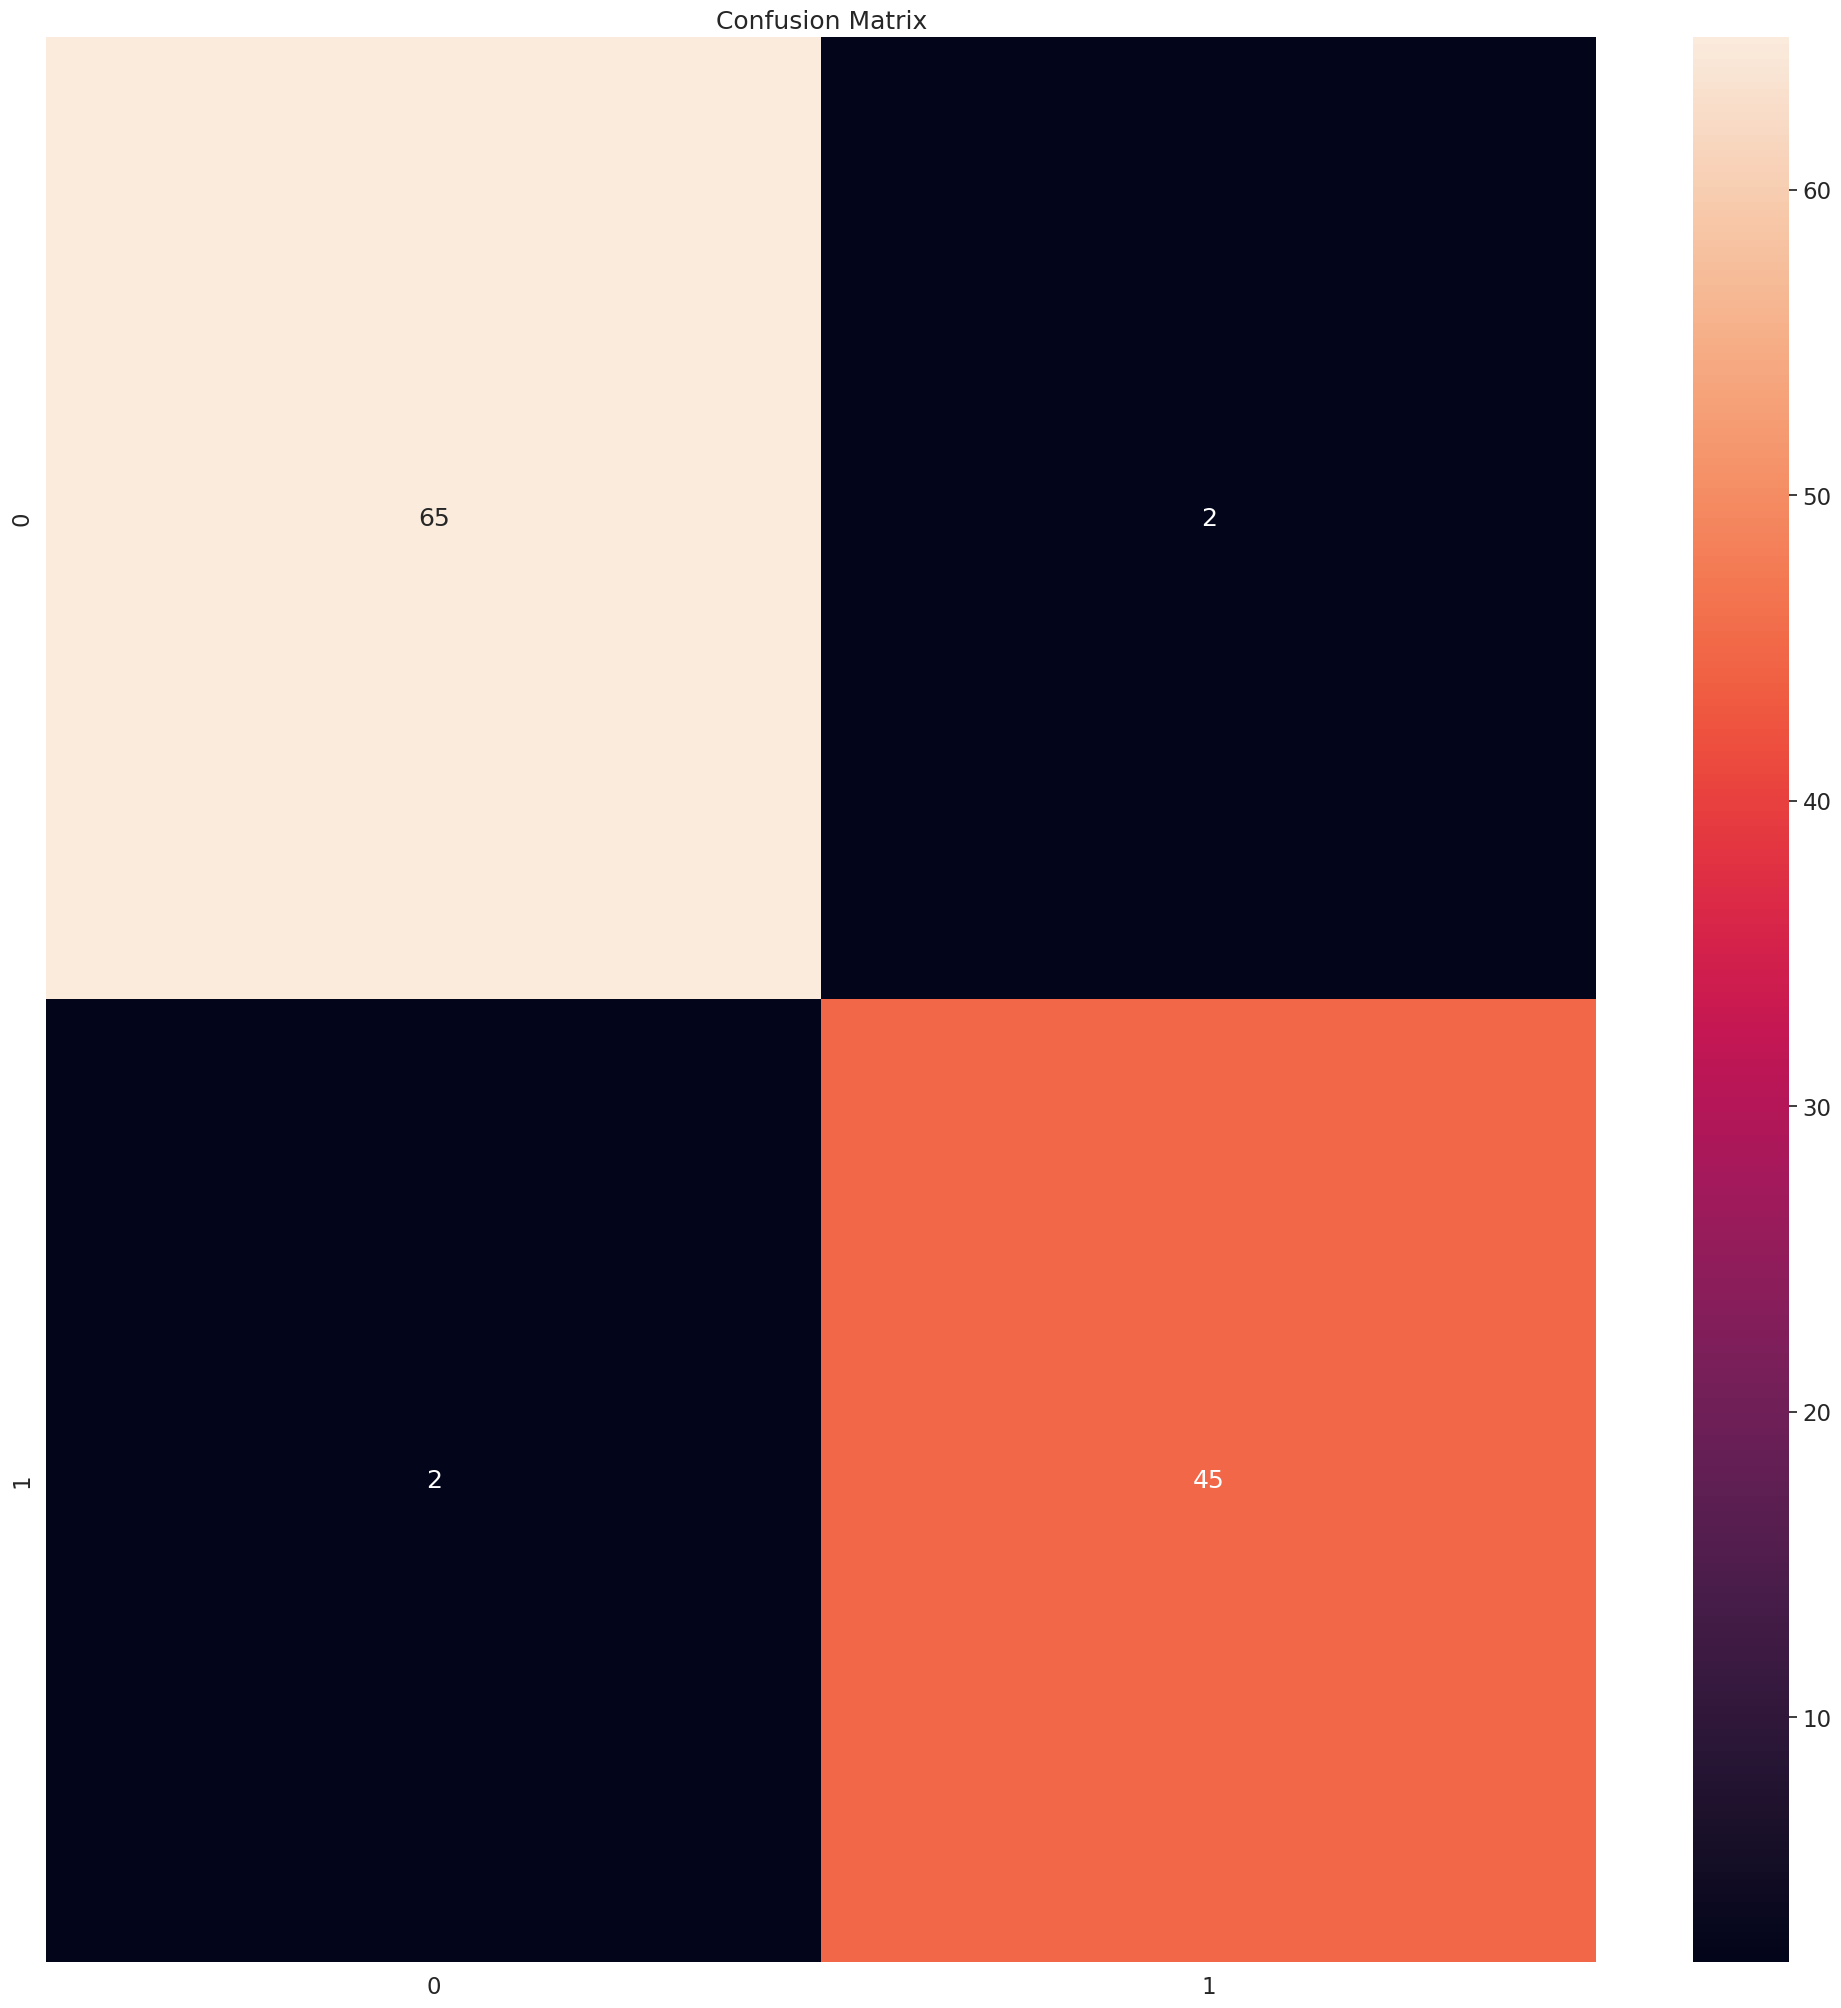

In [139]:
#Neural Network

processor_Neuro = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,batch_size=batch_size,epochs=epochs)
model = processor_Neuro.neuro_model()
processor_Neuro.models_metrics_neuro(model, Xtrain, ytrain, Xtest, ytest)
# Convert predictions to binary class labels
predition_1 = model.predict(Xtest, verbose=0) # Predict probabilities for the test set
predition_1 = np.argmax(predition_1, axis=1) # Get the class with the highest probability
model_neuro = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_neuro))
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix')

# Calculate permutation feature importance using the scoring function
result = permutation_importance(
    model, Xtest, ytest, n_repeats=10, random_state=0, scoring=processor_Neuro.scoring_fn
)
# Create a DataFrame to store the results
feature_importances = pd.DataFrame(
    {
        "feature": Lista_variaveis,  # Assuming Lista_variaveis contains feature names
        "importance": result.importances_mean,
    }
).sort_values("importance", ascending=False)


print('\n',feature_importances)


Best Parameters entropy 8

 KS Validation: 33.33% e AUC: 94.89%

  (np.float64(1.0), np.float64(0.0))

  KS Development: 33.33% e AUC: 100.00%

 (np.float64(1.0), np.float64(0.0))
importance    30
dtype: int64

Model Accuracy: 92.98%


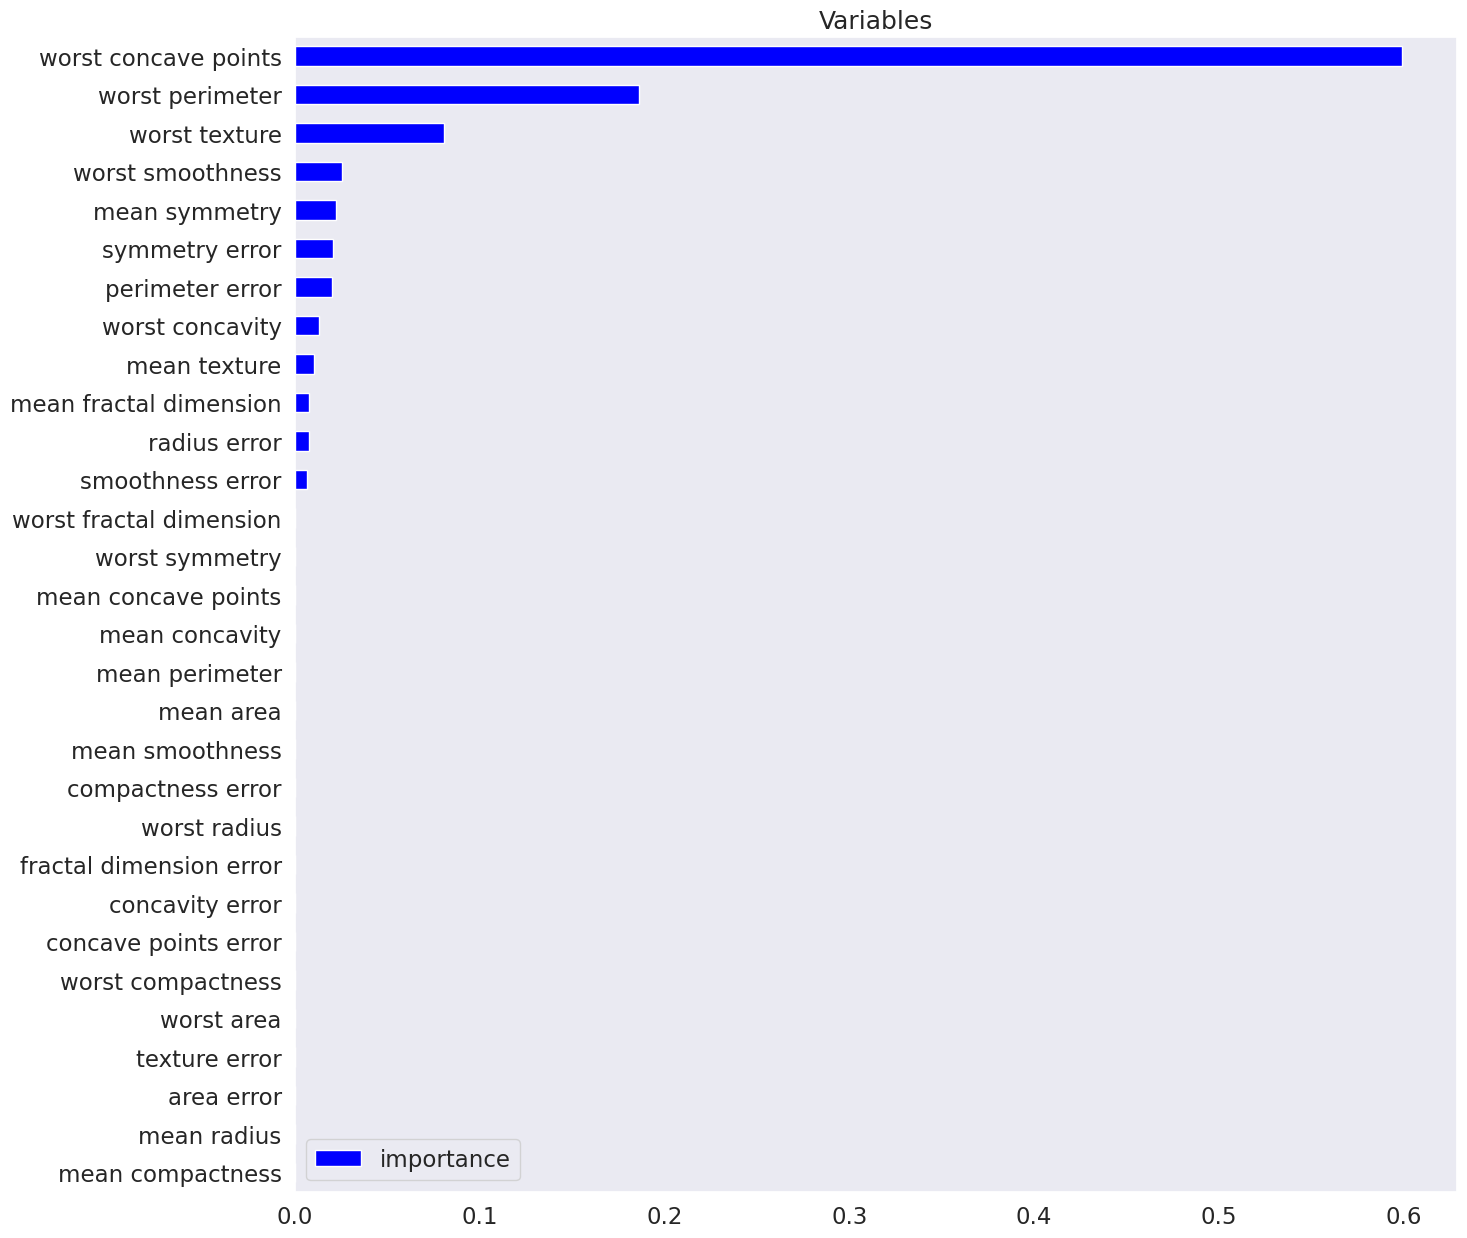

In [143]:
#Decission Tree

processor_decission_tree = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Decission Tree')
model= processor_decission_tree.tree_and_random_forest()
processor_decission_tree.models_metrics(model, Xtrain, ytrain, Xtest, ytest)
processor_decission_tree.models_metrics_random_tree(model, Xtrain, ytrain, Xtest, ytest)
predition_1 = model.predict(Xtest)
model_DecisionTree_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_DecisionTree_acc))


 Confussion Matrix
Text(0.5, 1.0, 'Confusion Matrix')


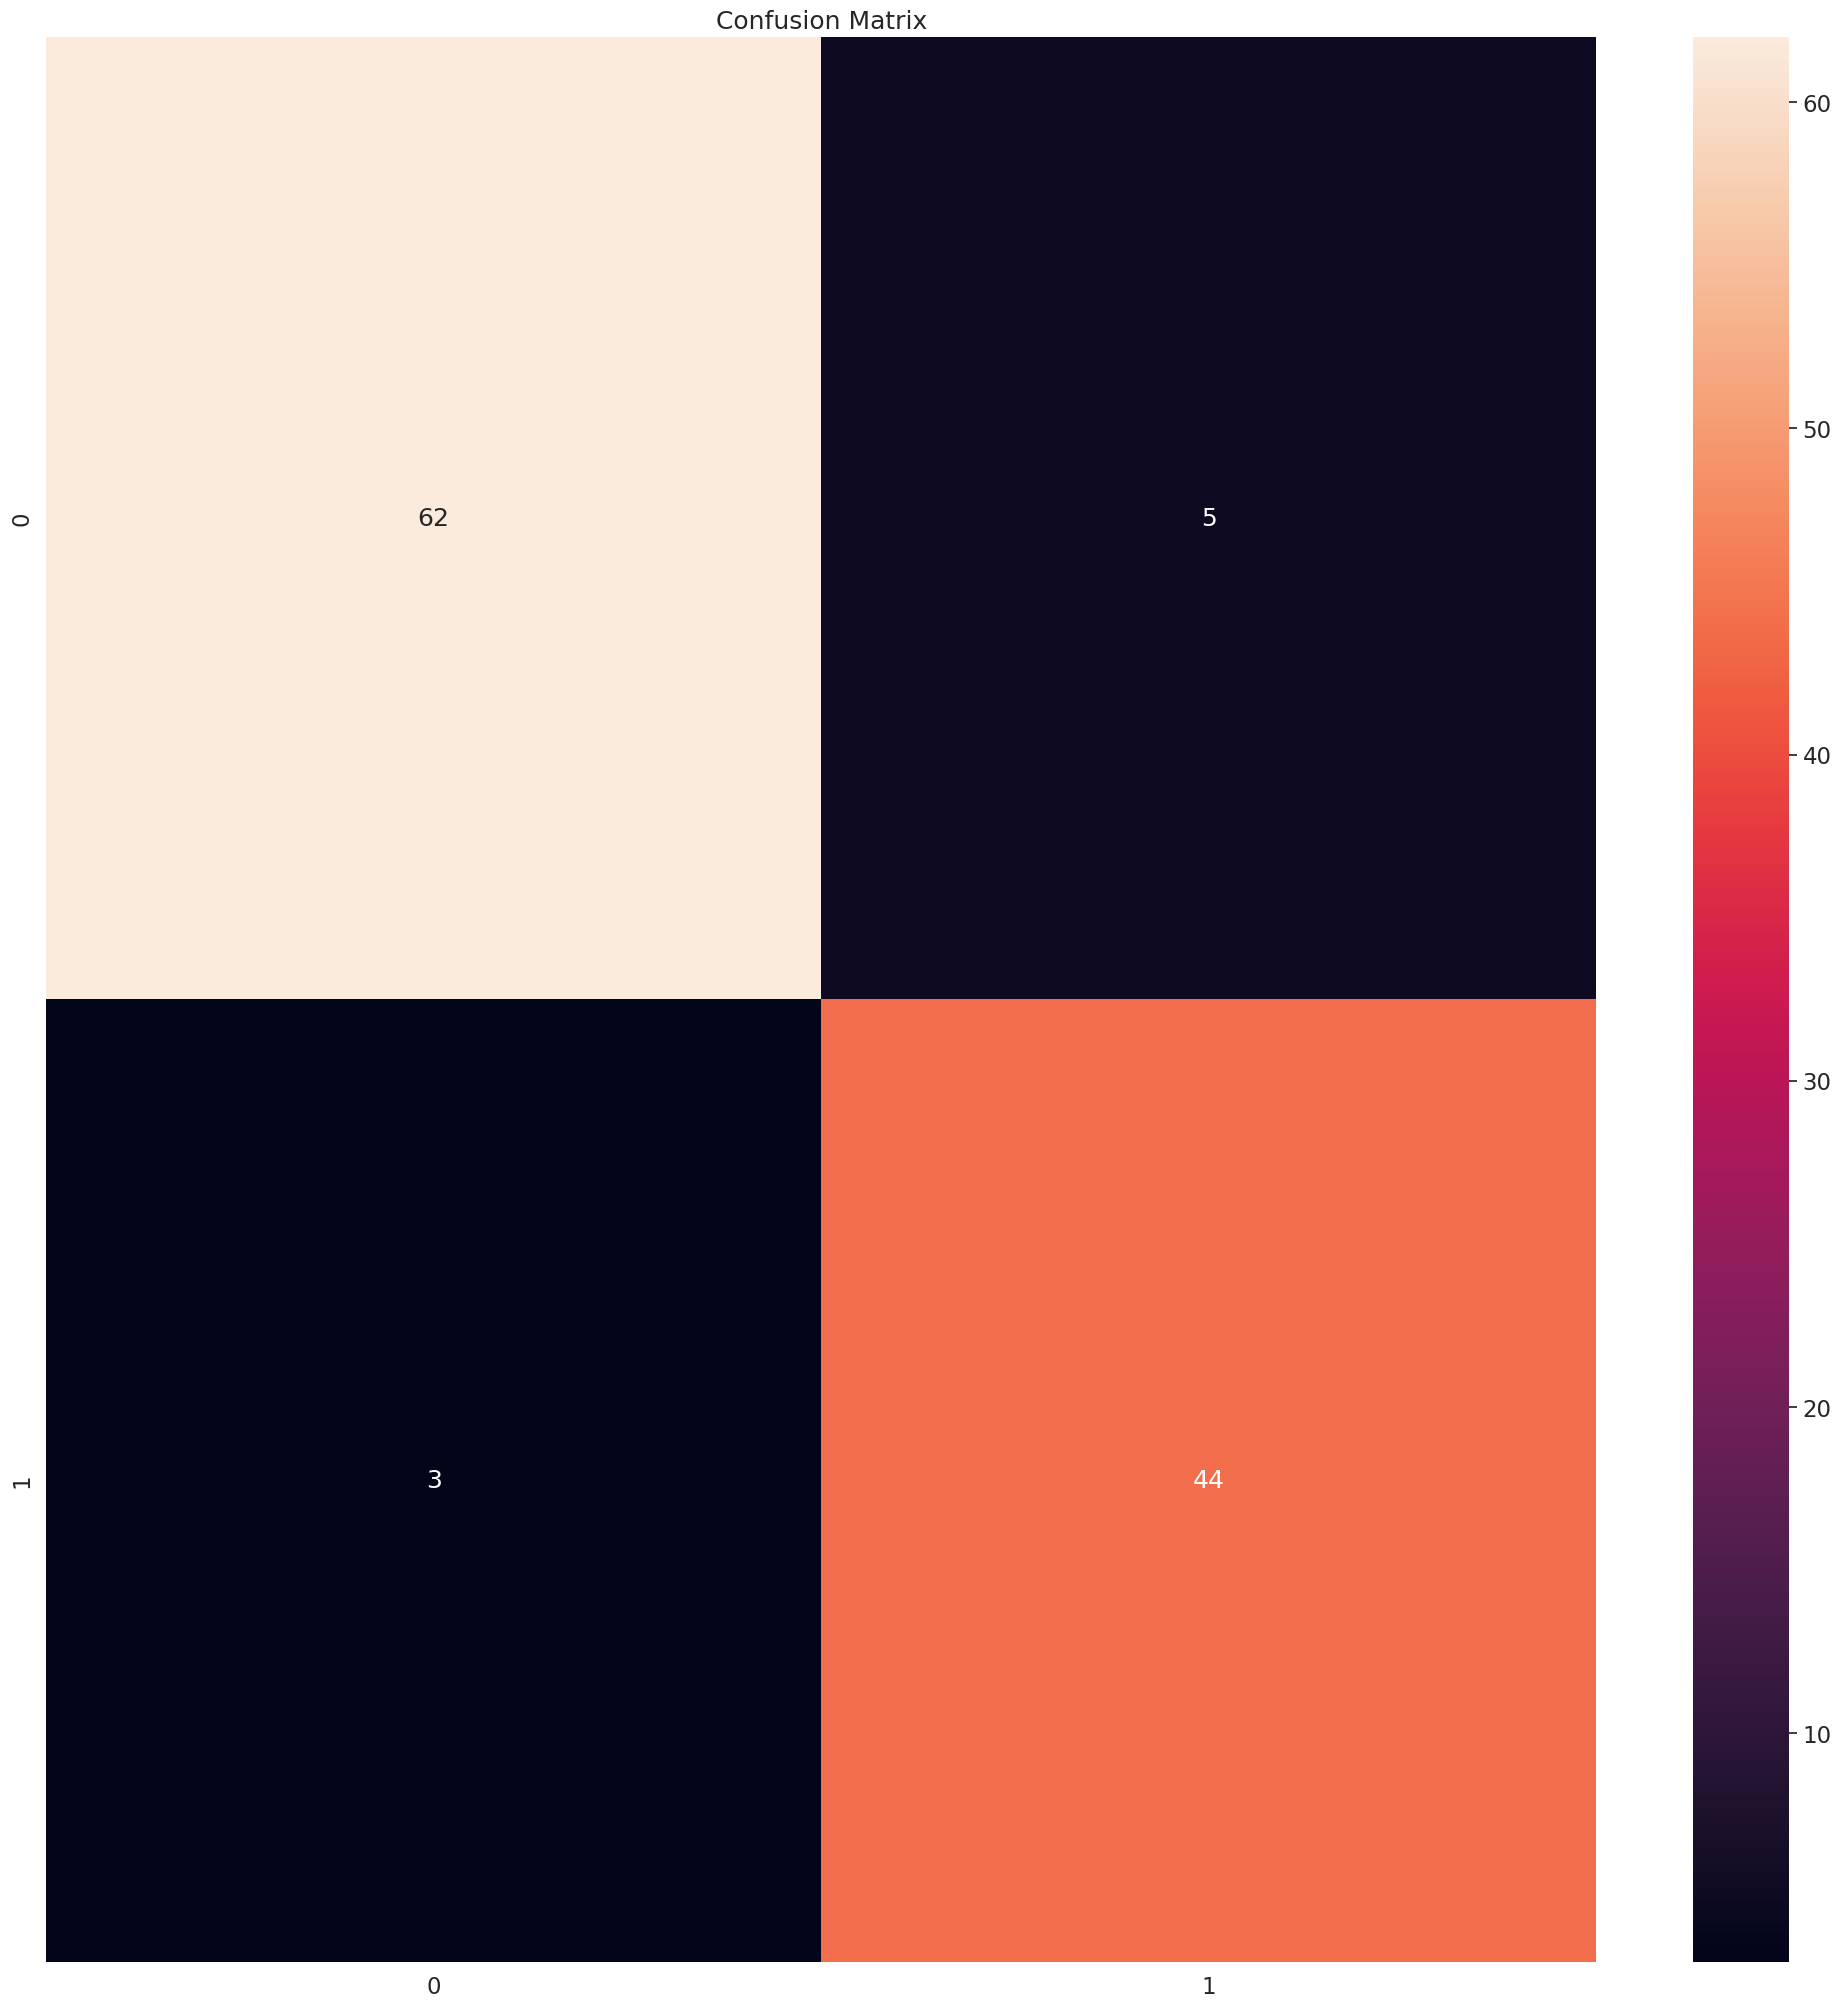

In [144]:
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
print(sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix'))

Best Parameters 50 6

 KS Validation: 65.00% e AUC: 99.62%

  (np.float64(0.9998473), np.float64(0.0004028))

  KS Development: 73.77% e AUC: 100.00%

 (np.float64(1.0), np.float64(7.41e-05))
importance    30
dtype: int64

Model Accuracy: 94.74%


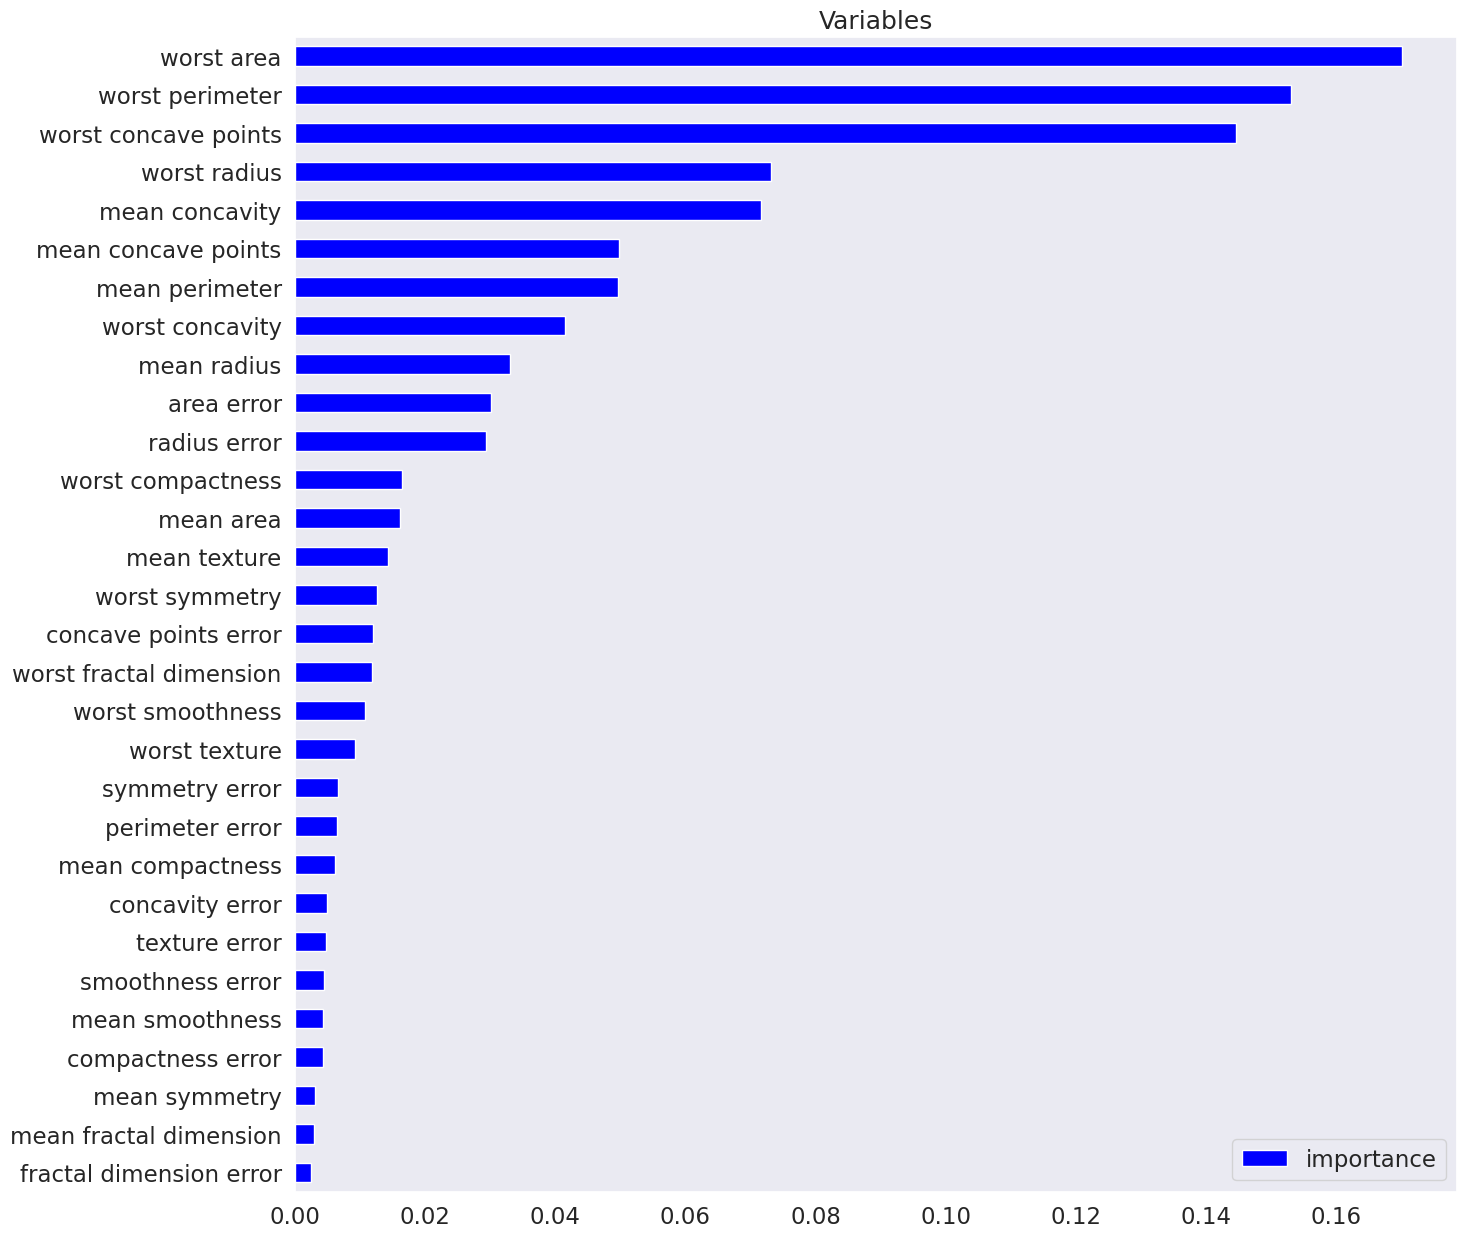

In [145]:
#Random Forest

processor_randomf = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.models_metrics(model, Xtrain, ytrain, Xtest, ytest)
processor_randomf.models_metrics_random_tree(model, Xtrain, ytrain, Xtest, ytest)
predition_1 = model.predict(Xtest)
model_RandomForest_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_RandomForest_acc))


 Confussion Matrix
Text(0.5, 1.0, 'Confusion Matrix')


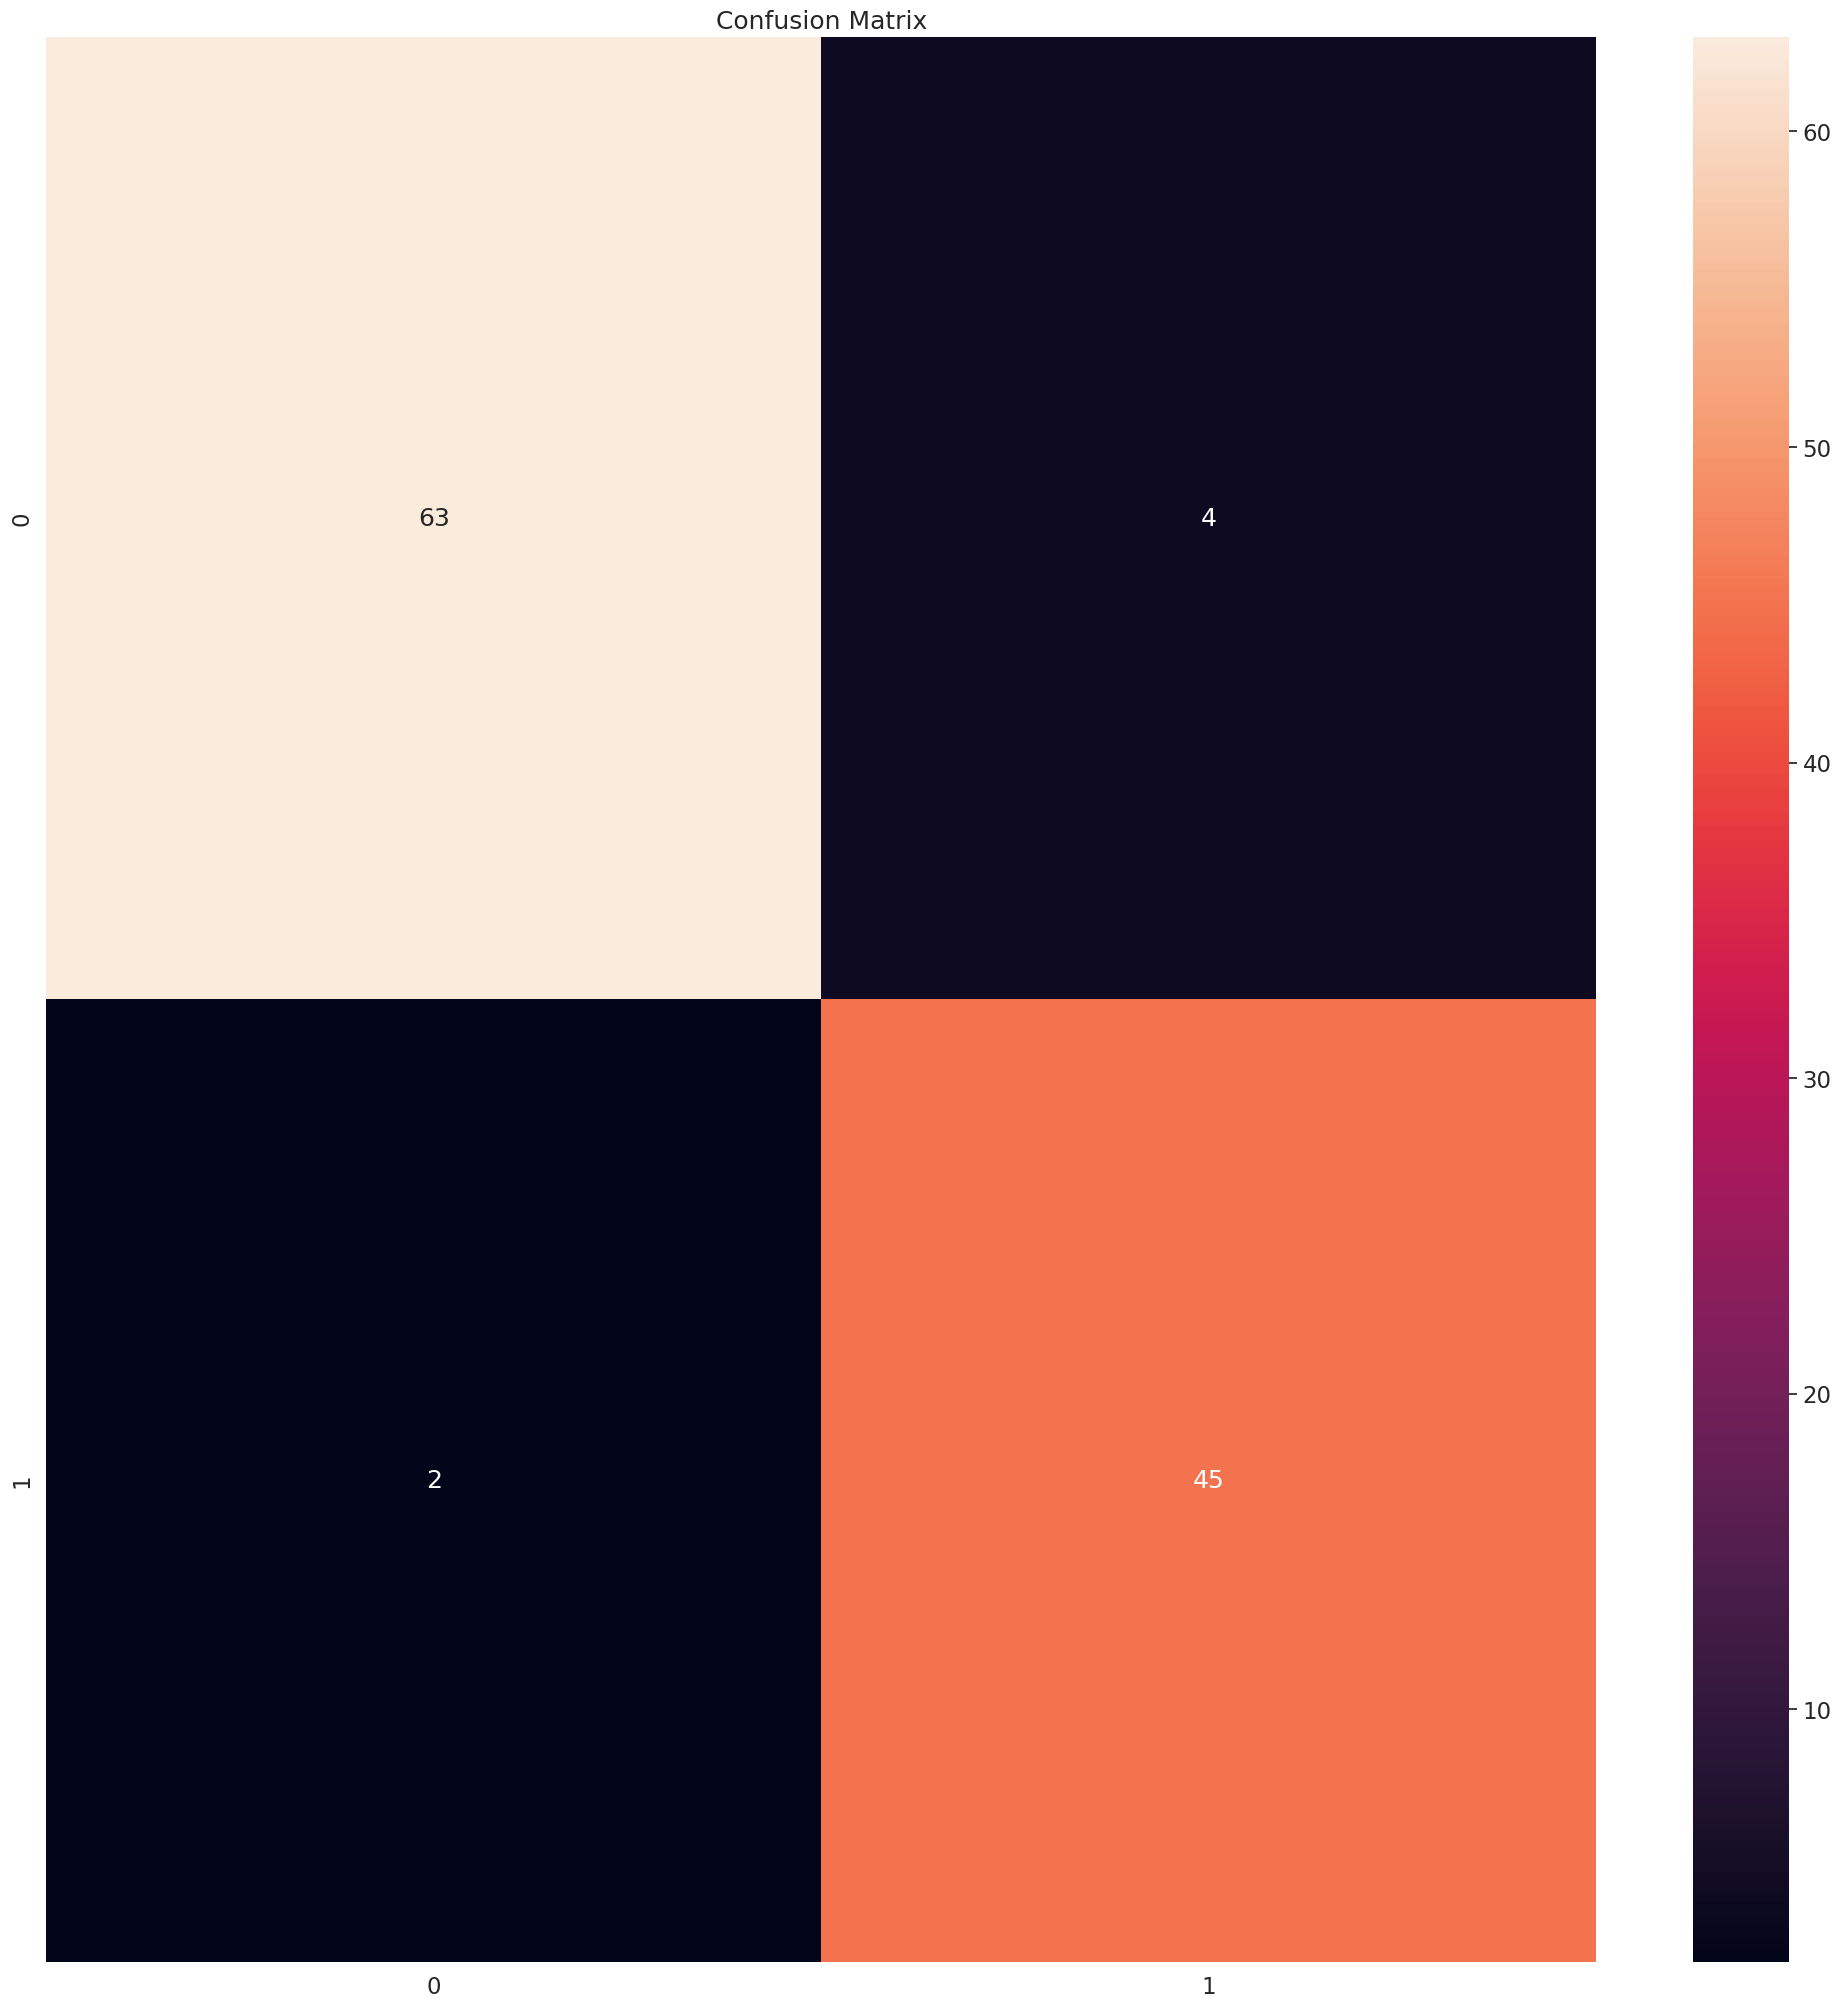

In [146]:
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
print(sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix'))

Best Parameters {'max_iter': 10, 'solver': 'lbfgs'}

 KS Validation: 62.50% e AUC: 99.68%

  (np.float64(0.9998523), np.float64(0.0013166))

  KS Development: 88.46% e AUC: 99.30%

 (np.float64(0.9999745), np.float64(0.0009992))

Model Accuracy: 95.61%


Text(0.5, 0, '\nPermutation Importance')

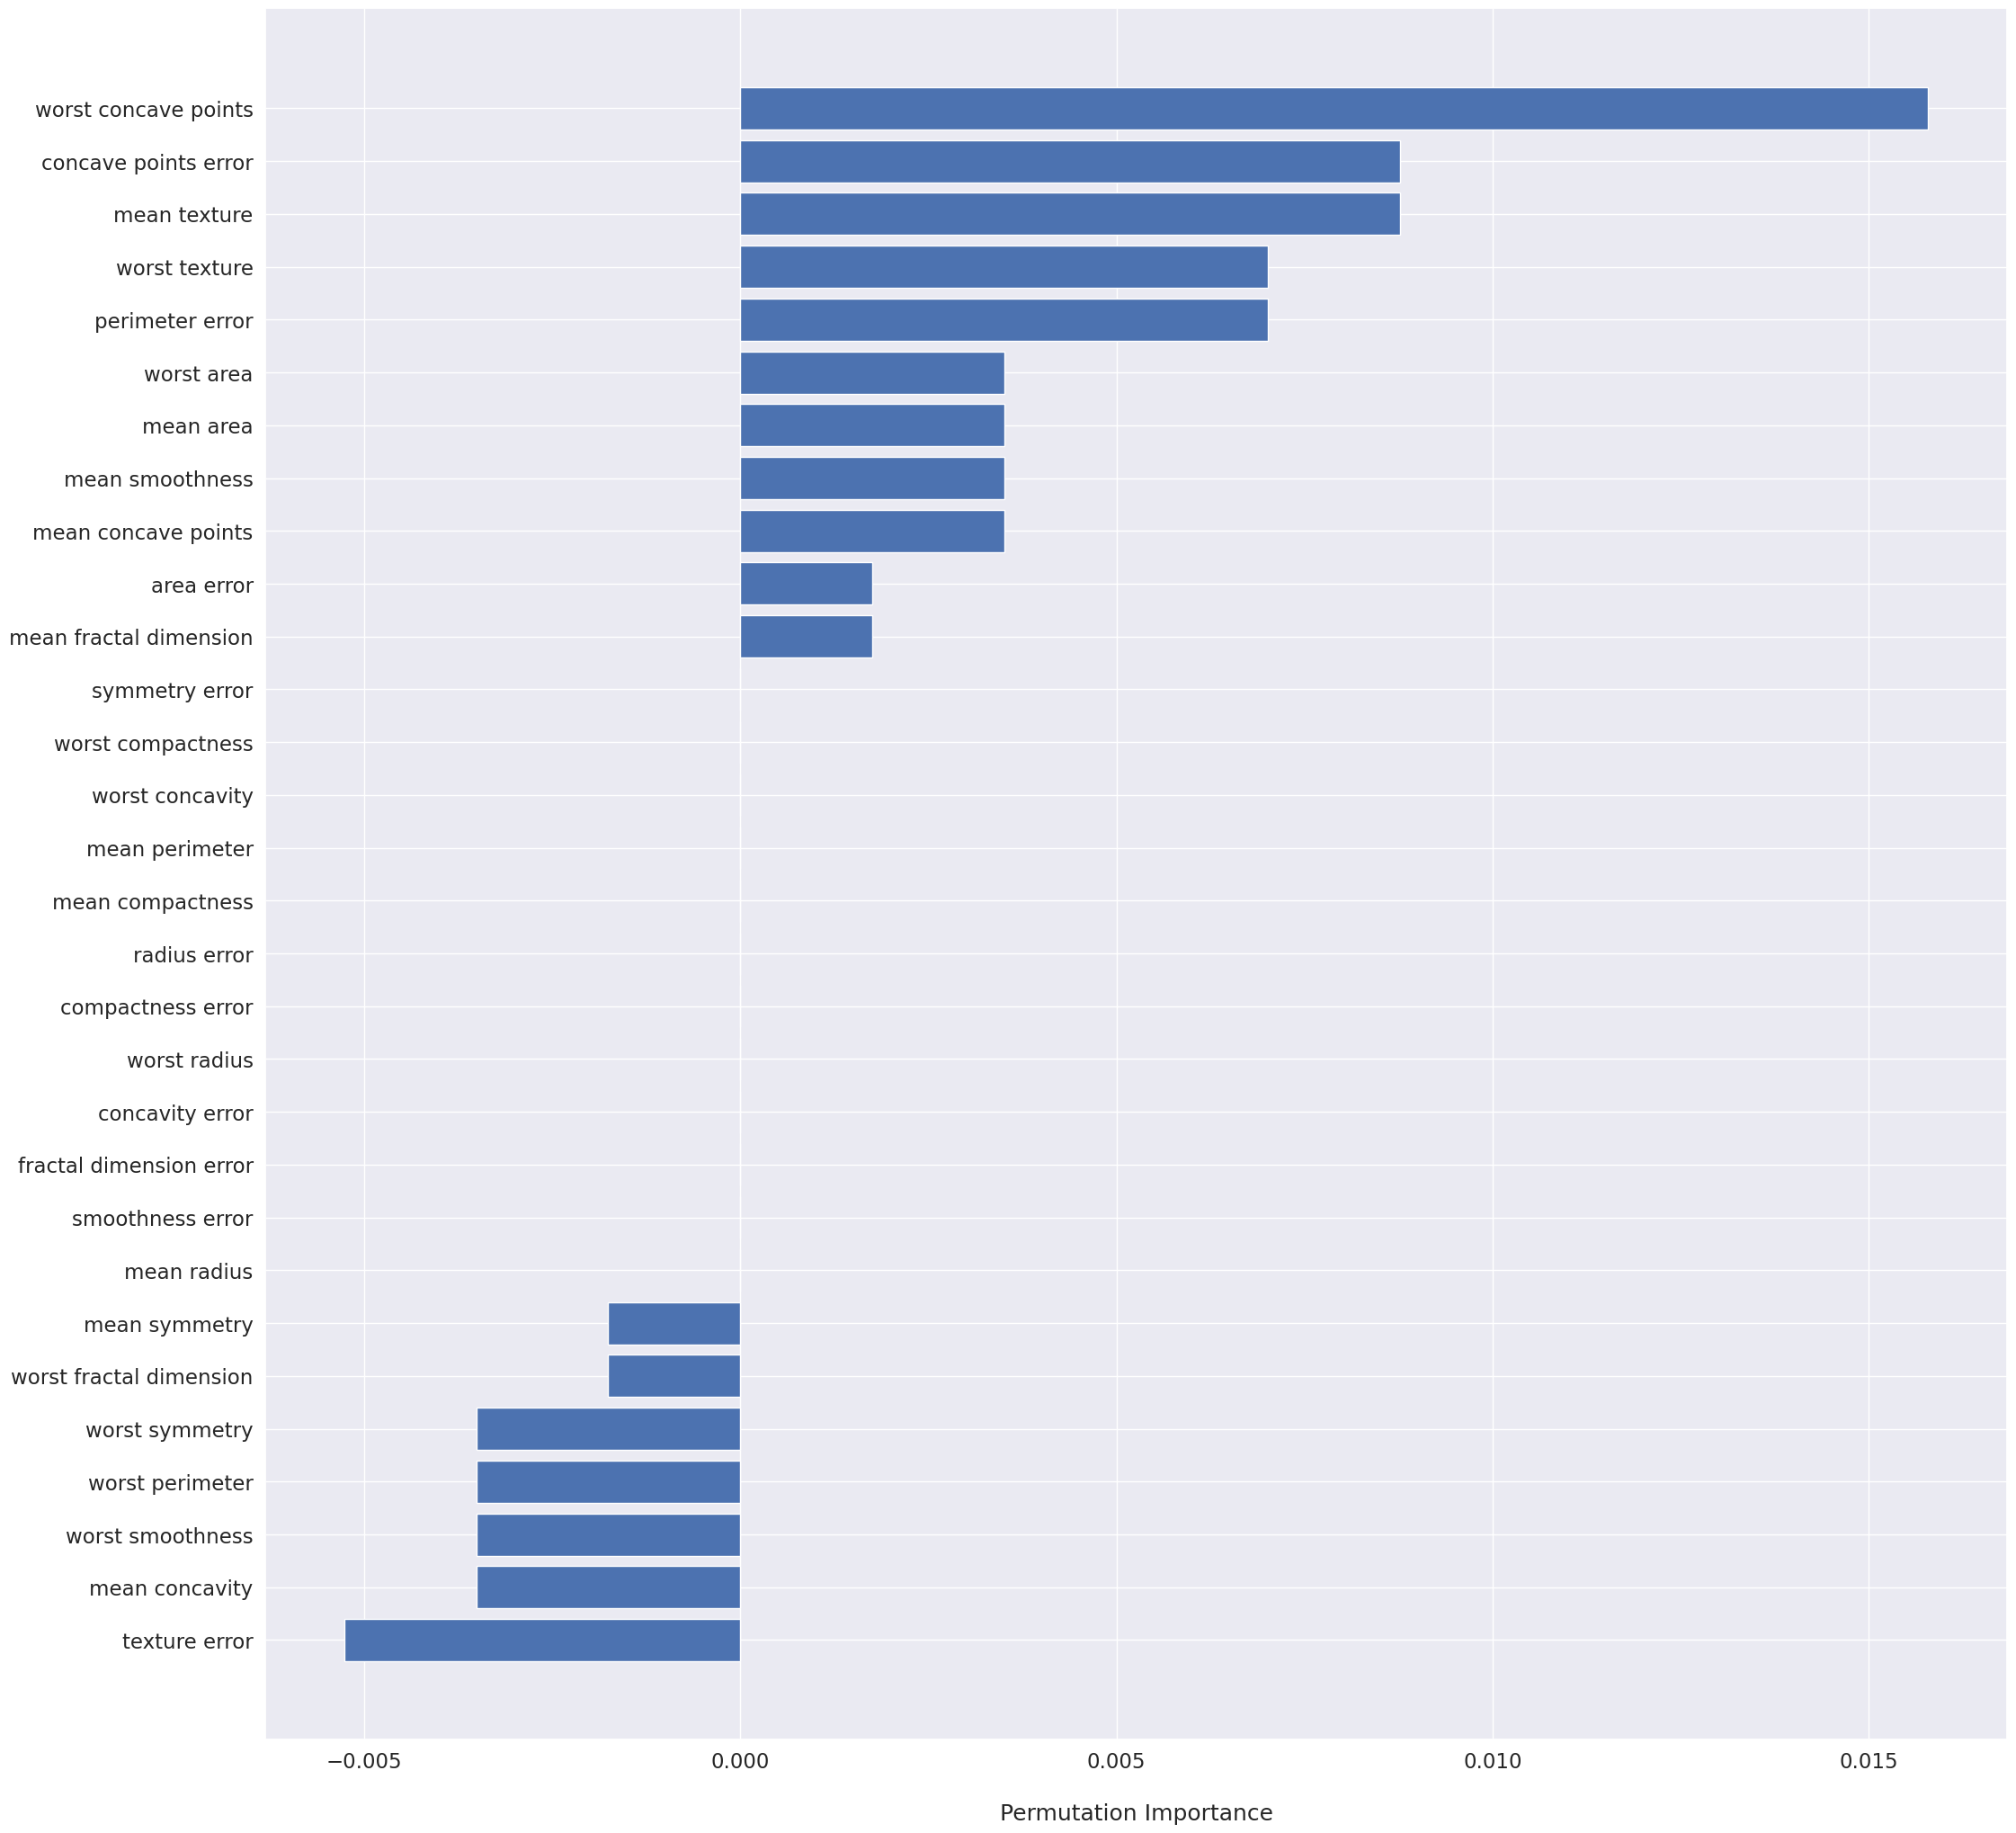

In [147]:
#Logistic Model

processor_logistic = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_logistic.logistic_model()
processor_logistic.models_metrics(model, Xtrain, ytrain, Xtest, ytest)
Logistic_model=model.predict_proba(Xtest)[:,1]
# Convert predicted probabilities to binary class labels using a threshold (e.g., 0.5)
Logistic_model_binary = (Logistic_model >= 0.5).astype(int)
model_Logistic_acc = accuracy_score(ytest, Logistic_model_binary)
print("\nModel Accuracy: {:.2%}".format(model_Logistic_acc))

#ytest = ytest.reshape(-1, 1)
model.fit(Xtrain, ytrain)
perm_importance = permutation_importance(model, Xtest, ytest)

feature_names = Lista_variaveis
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("\nPermutation Importance")


 Confussion Matrix
Text(0.5, 1.0, 'Confusion Matrix')


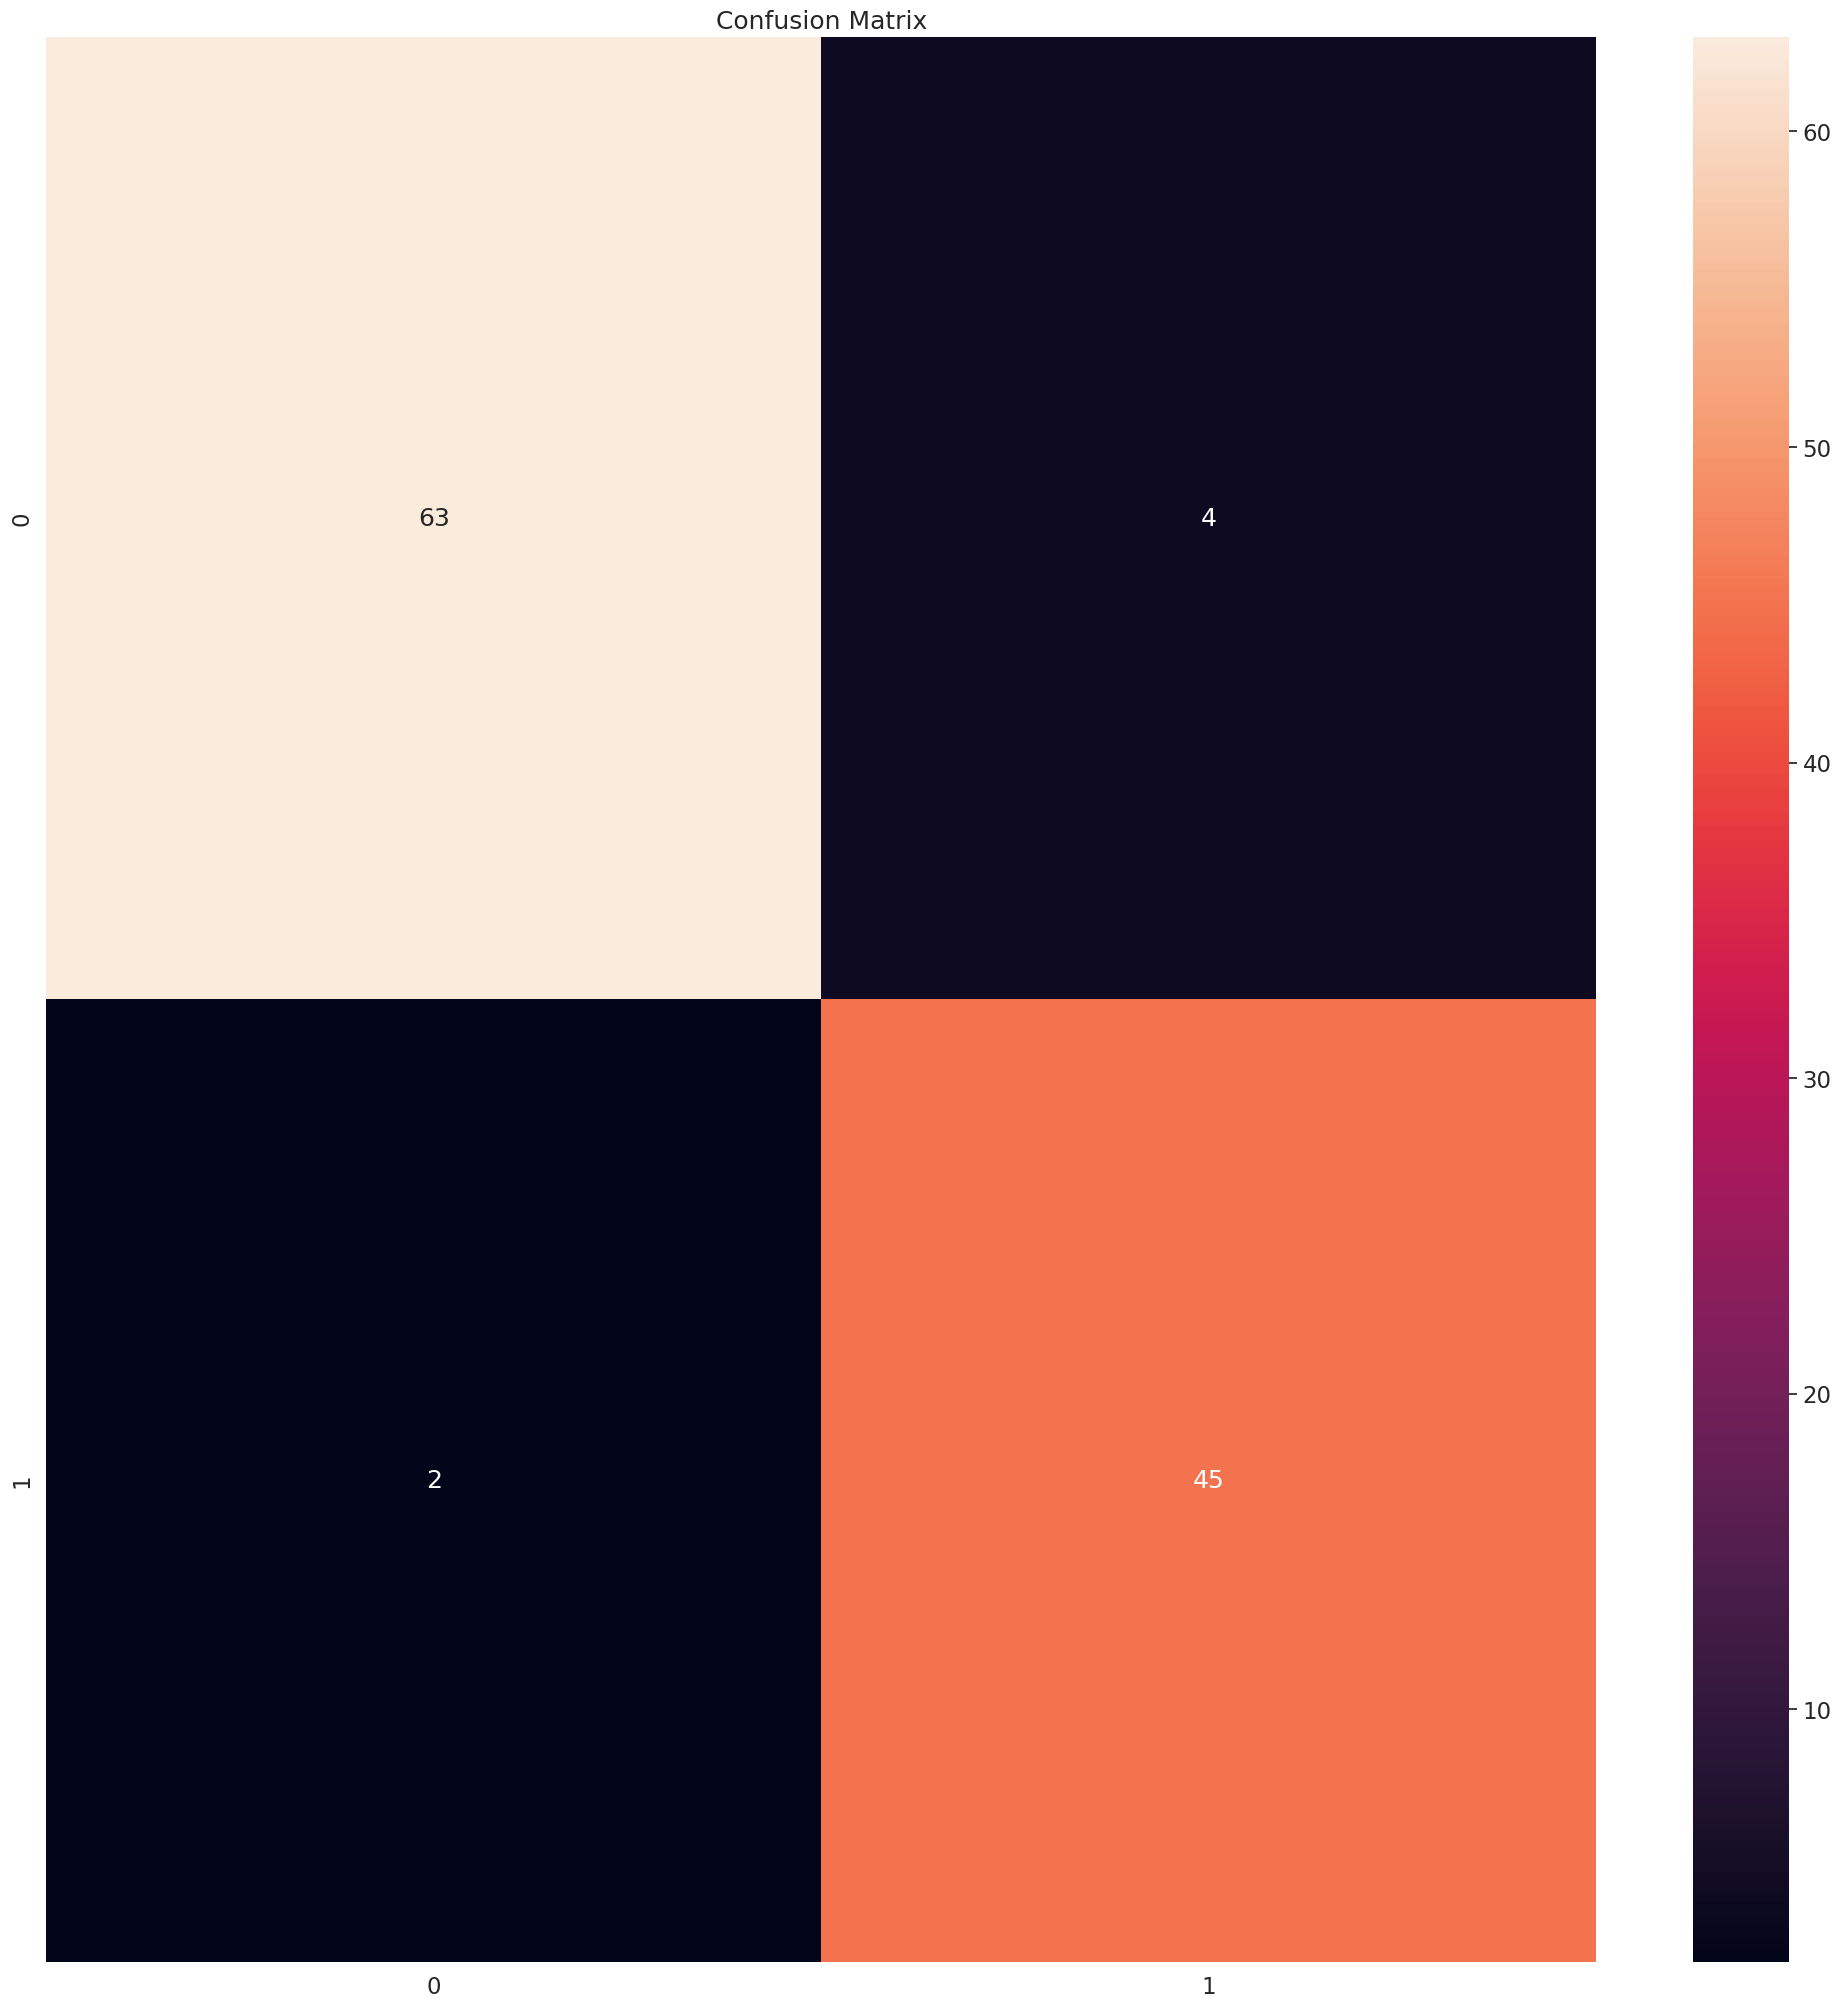

In [148]:
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
print(sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix'))


 KS Validation: 75.00% e AUC: 99.94%

  (np.float64(1.0), np.float64(0.0001608))

  KS Development: 86.21% e AUC: 99.48%

 (np.float64(1.0), np.float64(0.0001148))

Model Accuracy: 98.25%


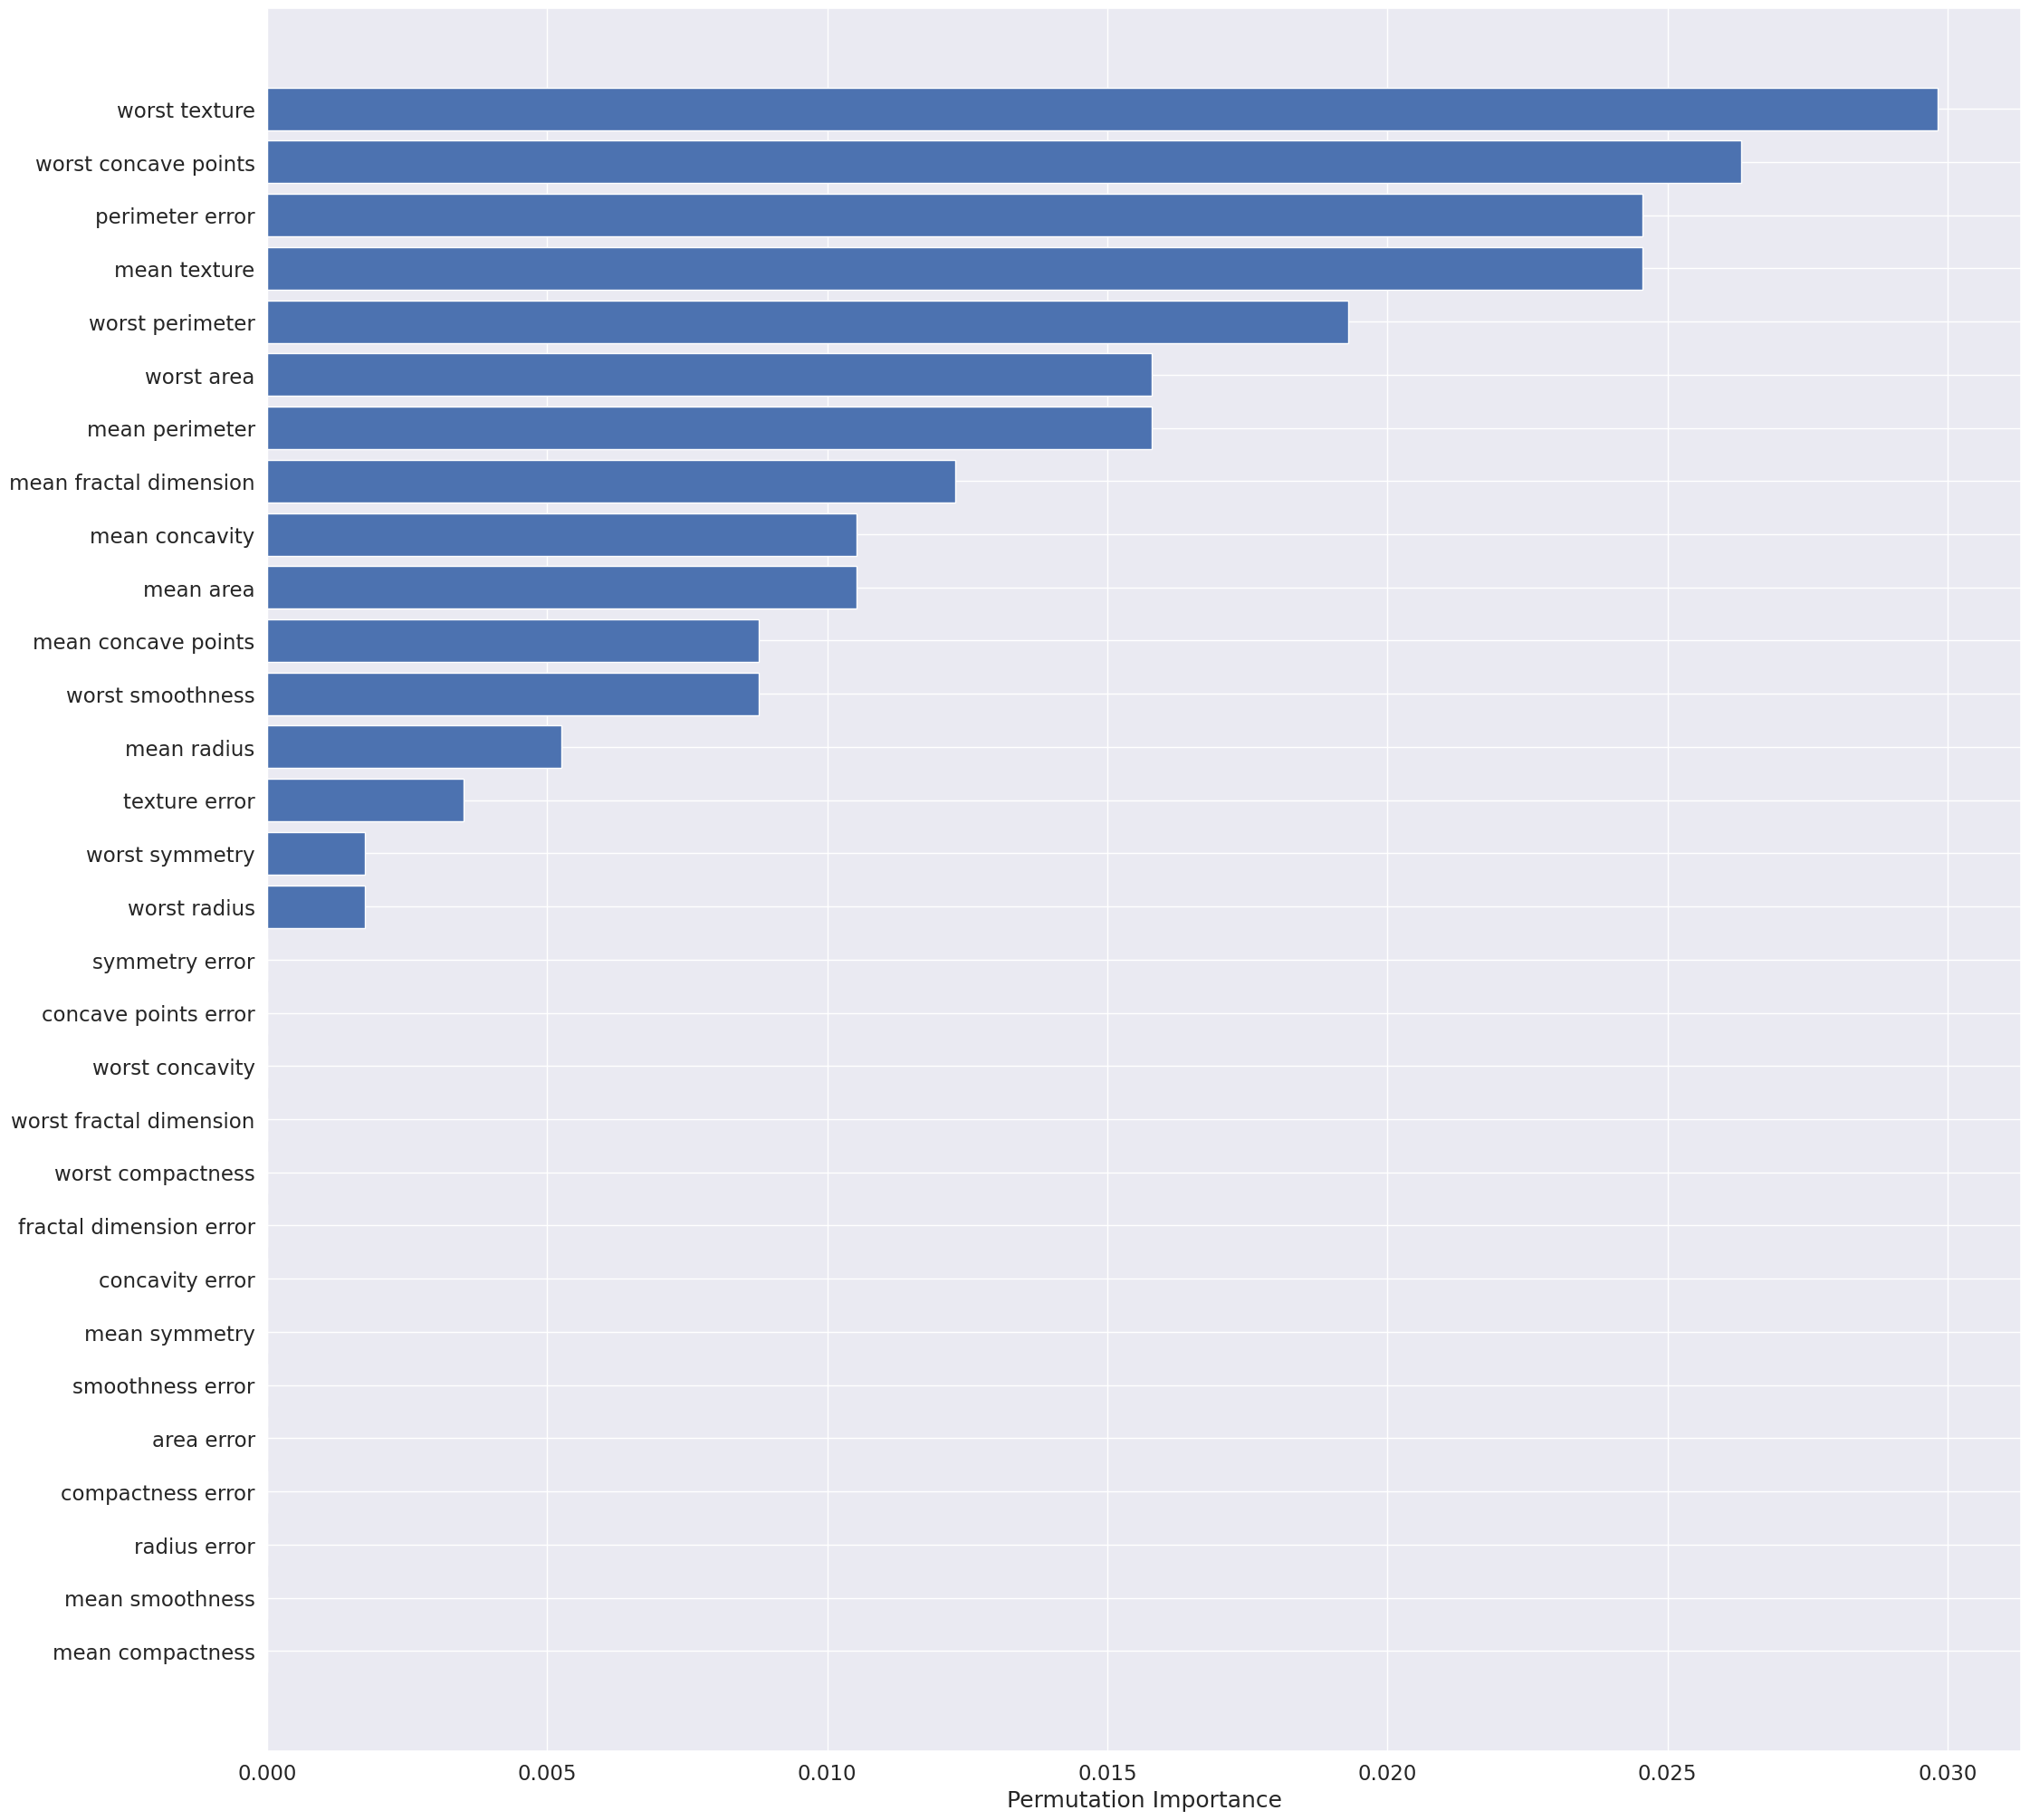

In [149]:
#SVM Model

processor_svm = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_svm.svm_model()
processor_svm.models_metrics(model, Xtrain, ytrain, Xtest, ytest)
processor_svm.models_metrics_svm(model, Xtrain, ytrain, Xtest, ytest)

predition_1 = model.predict(Xtest)
SVM_model_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(SVM_model_acc))


 Confussion Matrix
Text(0.5, 1.0, 'Confusion Matrix')


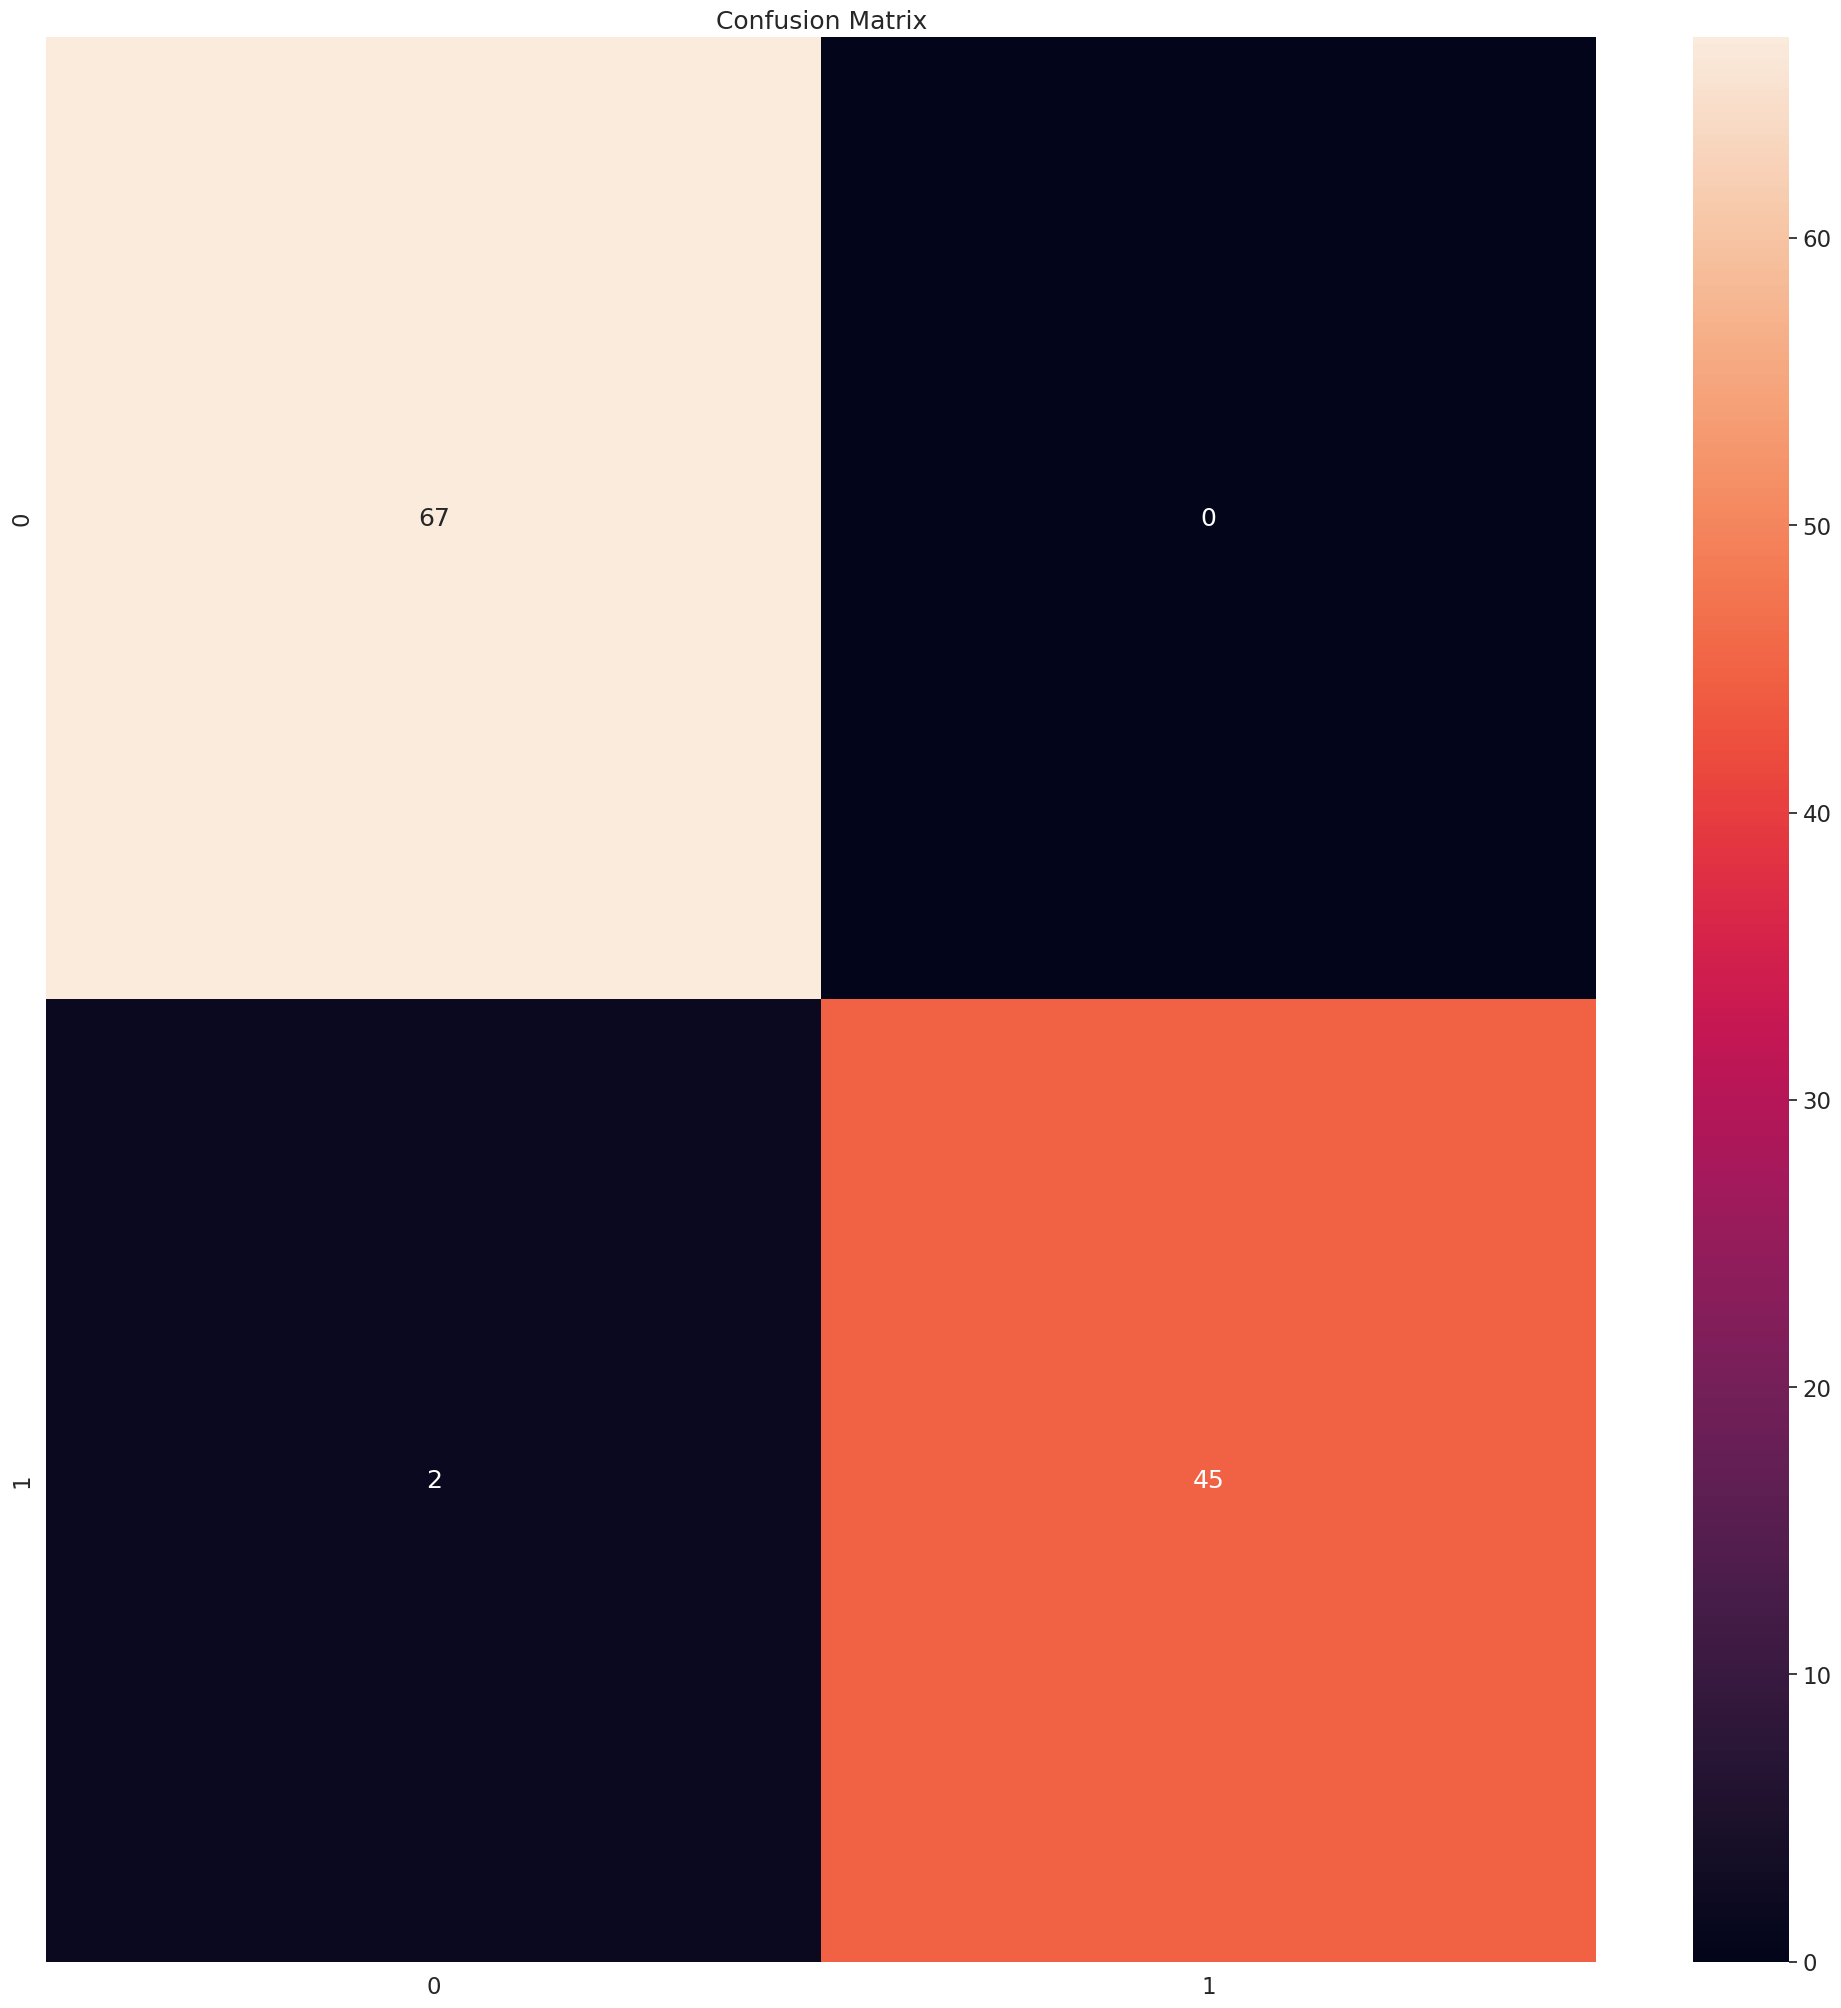

In [150]:
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
print(sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix'))

In [151]:
#KNN Model

processor_knn = models_types(X=Xtrain,y=ytrain,Lista_variaveis=Lista_variaveis)
model= processor_knn.knn_model()
processor_knn.models_metrics(model, Xtrain, ytrain, Xtest, ytest)

predition_1 = model.predict(Xtest)
KNN_model_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(KNN_model_acc))

Best Parameters {'n_neighbors': 3, 'p': 2}

 KS Validation: 60.00% e AUC: 98.13%

  (np.float64(1.0), np.float64(0.0))

  KS Development: 60.00% e AUC: 99.88%

 (np.float64(1.0), np.float64(0.0))

Model Accuracy: 94.74%



 Confussion Matrix
Text(0.5, 1.0, 'Confusion Matrix')


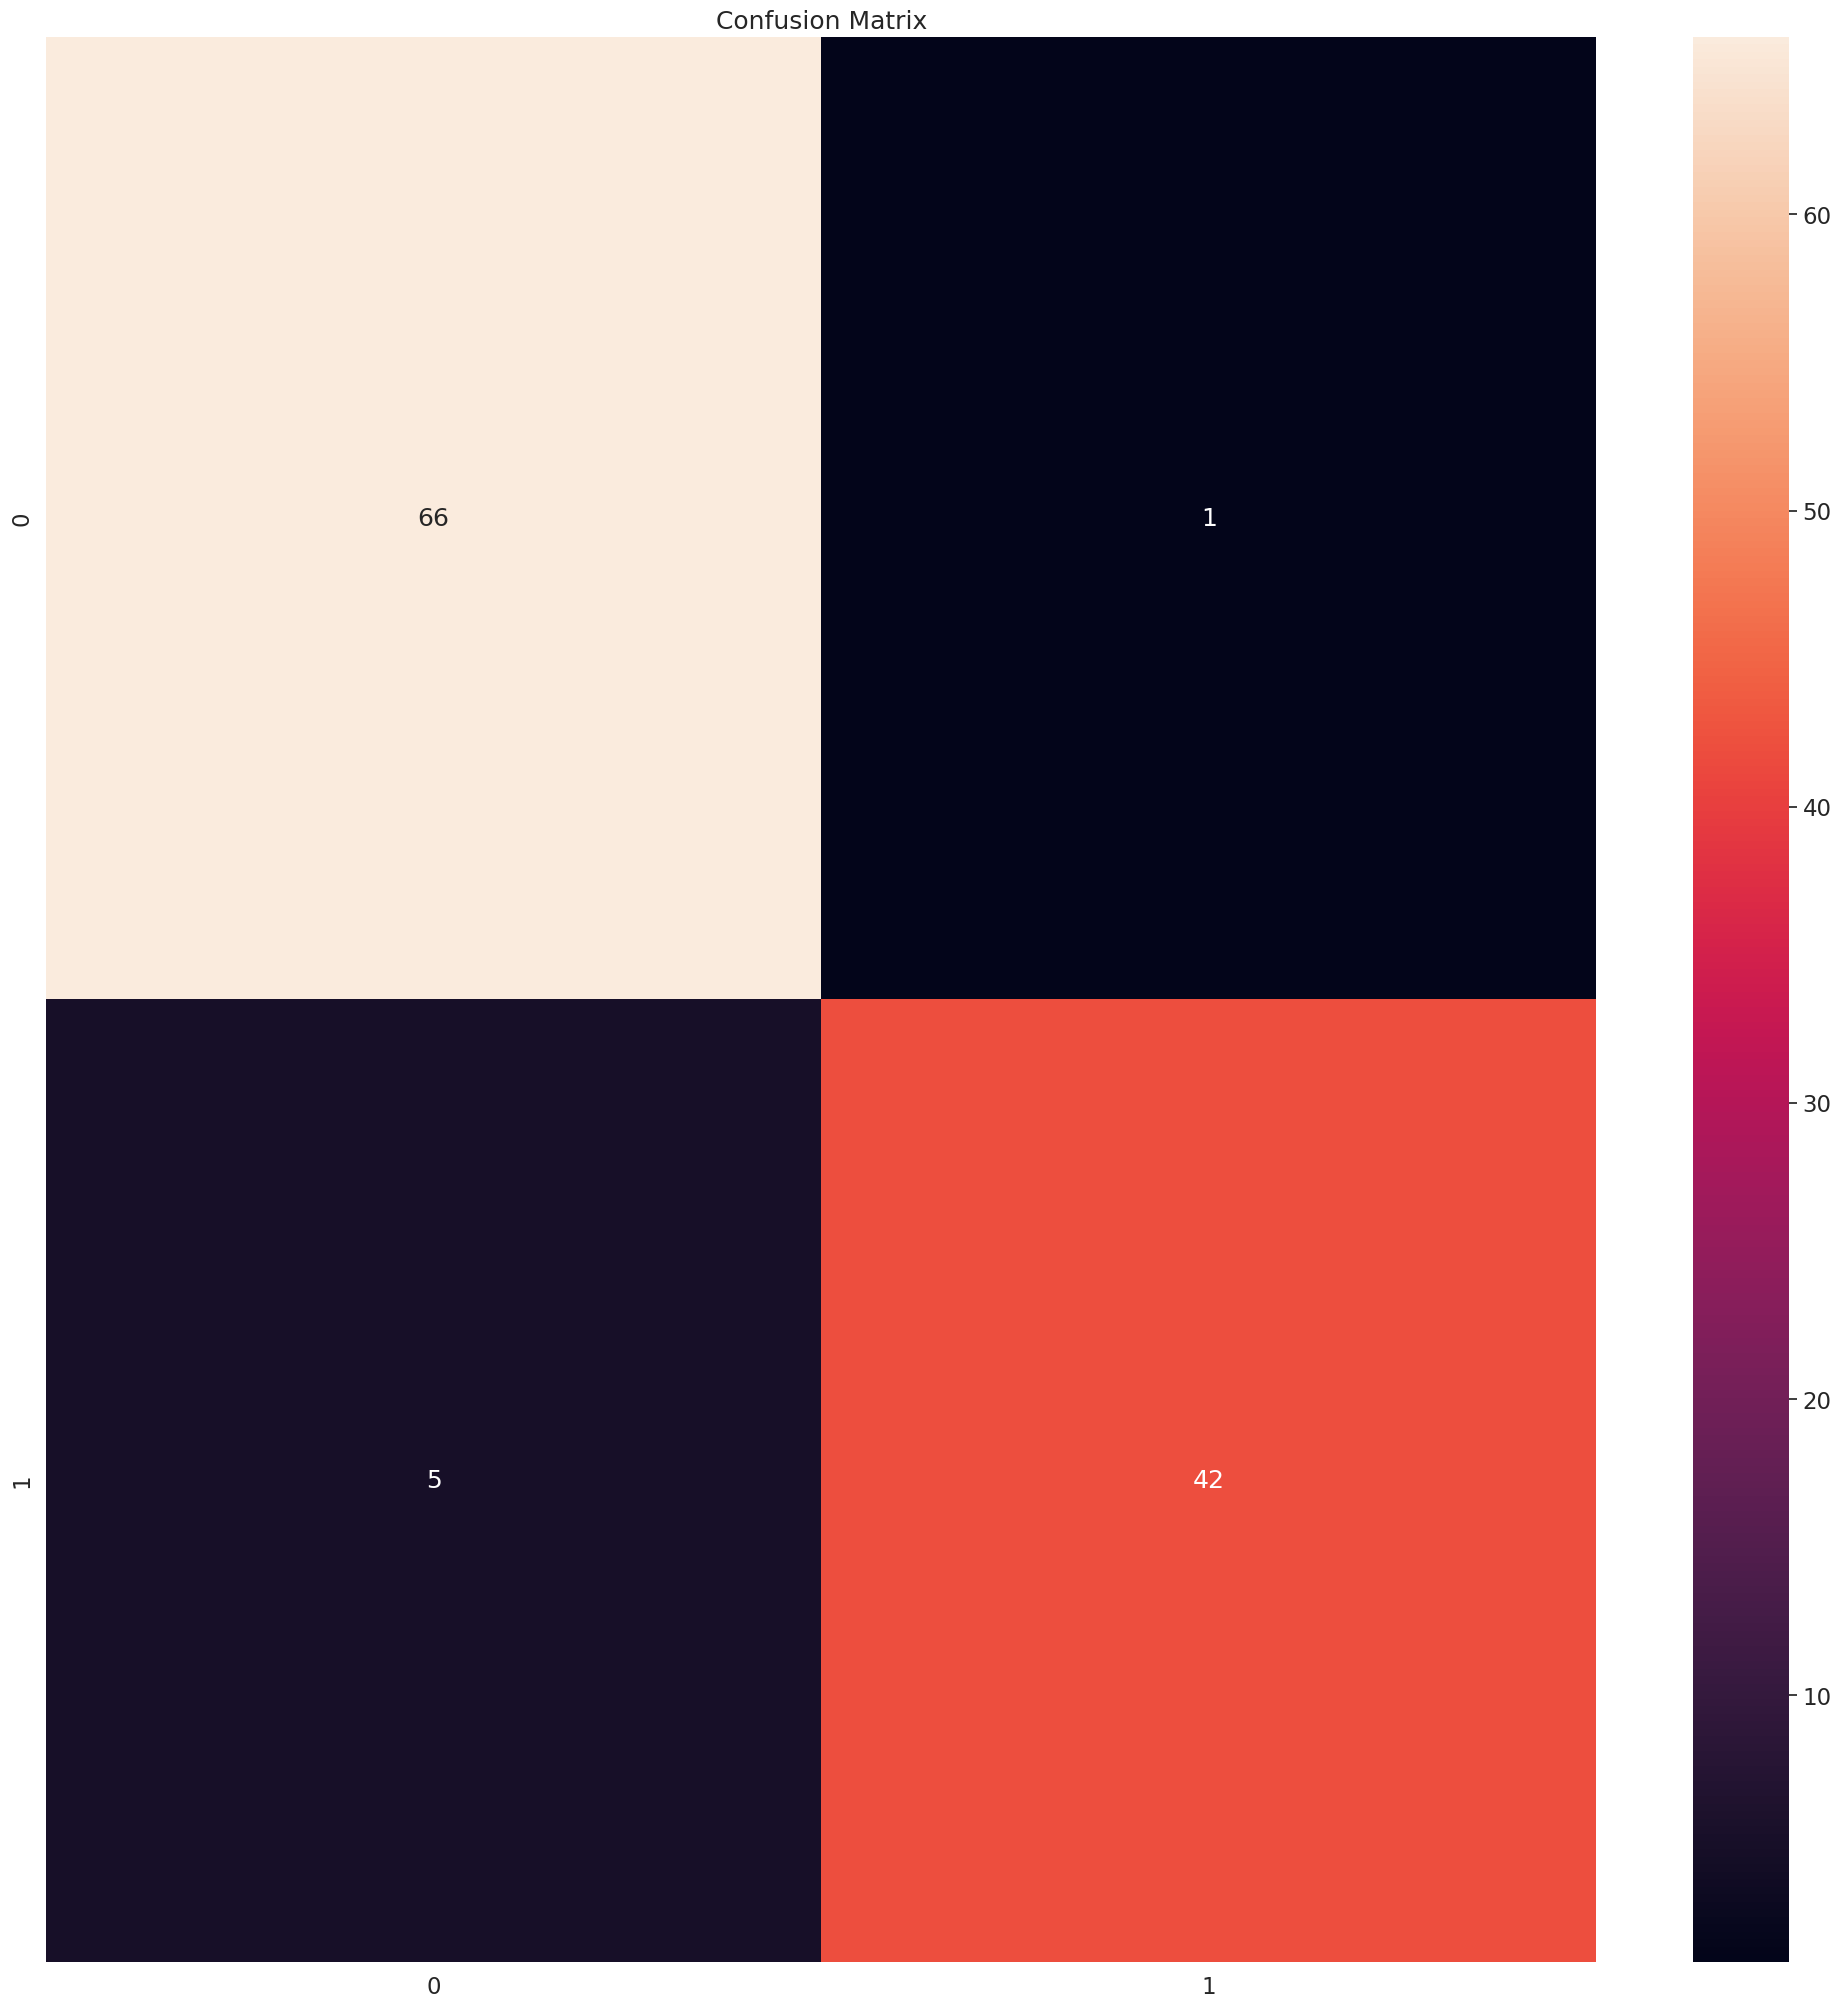

In [152]:
print('\n Confussion Matrix')
cf_matrix = confusion_matrix(ytest, predition_1)
print(sns.heatmap(cf_matrix, annot=True).set_title('Confusion Matrix'))

In [132]:
#PCA Method

#for k in range(2,len(Lista_variaveis)//2):
pca=PCA(n_components=3)
XTrain = pca.fit_transform(Xtrain)
XTest = pca.transform(Xtest)

processor_randomf = models_types(X=XTrain,y=ytrain,Lista_variaveis=Lista_variaveis,model_tree='Random Forest')
model= processor_randomf.tree_and_random_forest()
processor_randomf.models_metrics(model, XTrain, ytrain, XTest, ytest)
#processor_randomf.models_metrics_random_tree(model, XTrain, ytrain, XTest, ytest)


Best Parameters 100 5

 KS Validation: 64.29% e AUC: 98.86%

  (np.float64(0.9701557), np.float64(0.0114577))

  KS Development: 67.31% e AUC: 99.77%

 (np.float64(0.99875), np.float64(0.0047919))


In [136]:
predition_1 = model.predict(XTest)
model_RandomForest_acc = accuracy_score(ytest, predition_1)
print("\nModel Accuracy: {:.2%}".format(model_RandomForest_acc))


Model Accuracy: 92.11%


In [133]:
pca=PCA(n_components=3)
pca.fit(XTest)
X_pca=pca.transform(XTest)
base=pd.DataFrame(data=X_pca,columns=['PC1','PC2','PC3'])
base['Cluster']=model.predict(XTest)
base
color_theme = np.array(['red','green'])


In [134]:
df = base
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3',
              color=color_theme[base['Cluster']])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
y_pred=model.predict(X, verbose=0)
y_pred = [np.argmax(v) for v in y_pred]
X1 = processor.min_max_scaler.inverse_transform(X)
df = pd.DataFrame(data=X1, columns=Lista_variaveis)
df2 = pd.DataFrame(data=y,columns=['Tarq'])
df3 = pd.DataFrame(data=y_pred,columns=['Pred'])
df = pd.concat([df,df2,df3],axis=1)


In [ ]:
df.round(decimals=2).to_csv('df.csv',index=False)